## Module Imports

In [205]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Mount Google Drive to Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding

### **Identify datasets with NaN or None values**

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
db = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Week1_challenge_data_source(CSV).csv', na_values=['undefined','?', None])
db.head() # the fisrt five rows

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,42.0,5.0,23.0,44.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,37624.0,38787.0,1.823653e+09,Samsung,Samsung Galaxy A5 Sm-A520F,NaN,NaN,NaN,NaN,NaN,NaN,213.0,214.0,1545765.0,24420.0,1634479.0,1271433.0,3563542.0,137762.0,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,65.0,5.0,16.0,26.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,168.0,3560.0,1.365104e+09,Samsung,Samsung Galaxy J5 (Sm-J530),NaN,NaN,NaN,NaN,NaN,NaN,971.0,1022.0,1926113.0,7165.0,3493924.0,920172.0,629046.0,308339.0,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,NaN,NaN,6.0,9.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.361763e+09,Samsung,Samsung Galaxy A8 (2018),NaN,NaN,NaN,NaN,NaN,NaN,751.0,695.0,1684053.0,42224.0,8535055.0,1694064.0,2690151.0,672973.0,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,NaN,NaN,44.0,44.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,3330.0,37882.0,1.321510e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,207.0,644121.0,13372.0,9023734.0,2788027.0,1439754.0,631229.0,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,NaN,NaN,6.0,9.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.089009e+09,Samsung,Samsung Sm-G390F,NaN,NaN,NaN,NaN,NaN,NaN,607.0,604.0,862600.0,50188.0,6248284.0,1500559.0,1936496.0,173853.0,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


# Size of the dataset
### Columns of the dataset

In [5]:
# list of column  names
db.columns.tolist()

['Bearer Id',
 'Start',
 'Start ms',
 'End',
 'End ms',
 'Dur. (ms)',
 'IMSI',
 'MSISDN/Number',
 'IMEI',
 'Last Location Name',
 'Avg RTT DL (ms)',
 'Avg RTT UL (ms)',
 'Avg Bearer TP DL (kbps)',
 'Avg Bearer TP UL (kbps)',
 'TCP DL Retrans. Vol (Bytes)',
 'TCP UL Retrans. Vol (Bytes)',
 'DL TP < 50 Kbps (%)',
 '50 Kbps < DL TP < 250 Kbps (%)',
 '250 Kbps < DL TP < 1 Mbps (%)',
 'DL TP > 1 Mbps (%)',
 'UL TP < 10 Kbps (%)',
 '10 Kbps < UL TP < 50 Kbps (%)',
 '50 Kbps < UL TP < 300 Kbps (%)',
 'UL TP > 300 Kbps (%)',
 'HTTP DL (Bytes)',
 'HTTP UL (Bytes)',
 'Activity Duration DL (ms)',
 'Activity Duration UL (ms)',
 'Dur. (ms).1',
 'Handset Manufacturer',
 'Handset Type',
 'Nb of sec with 125000B < Vol DL',
 'Nb of sec with 1250B < Vol UL < 6250B',
 'Nb of sec with 31250B < Vol DL < 125000B',
 'Nb of sec with 37500B < Vol UL',
 'Nb of sec with 6250B < Vol DL < 31250B',
 'Nb of sec with 6250B < Vol UL < 37500B',
 'Nb of sec with Vol DL < 6250B',
 'Nb of sec with Vol UL < 1250B',
 'Socia

### Number of columns

In [6]:
print(f"Number of columns: ", len(db.columns))

Number of columns:  55


### Number of data points and data size

In [7]:
print(f" There are {db.shape[0]} rows and {db.shape[1]} columns")

 There are 150001 rows and 55 columns


### Features/columns and their data type

In [8]:
db.dtypes

Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mb



```
# This is formatted as code
```

### Utility Functions

In [9]:
# how many missing values exist or better still what is the % of missing values in the dataset?
def percent_missing(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 3), "%", "missing values.")

percent_missing(db)




The dataset contains 12.72 % missing values.


In [10]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

def format_float(value):
    return f'{value:,.2f}'

def find_agg(df:pd.DataFrame, agg_column:str, agg_metric:str, col_name:str, top:int, order=False )->pd.DataFrame:
    
    new_df = df.groupby(agg_column)[agg_column].agg(agg_metric).reset_index(name=col_name).\
                        sort_values(by=col_name, ascending=order)[:top]
    
    return new_df

def convert_bytes_to_megabytes(df, bytes_data):
    """
        This function takes the dataframe and the column which has the bytes values
        returns the megabytesof that value
        
        Args:
        -----
        df: dataframe
        bytes_data: column with bytes values
        
        Returns:
        --------
        A series
    """
    
    megabyte = 1*10e+5
    df[bytes_data] = df[bytes_data] / megabyte
    return df[bytes_data]

def fix_outlier(df, column):
    df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(),df[column])
    
    return df[column]


###################################PLOTTING FUNCTIONS###################################

def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()
    
def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()

def plot_heatmap(df:pd.DataFrame, title:str, cbar=False)->None:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', linewidths=.7, cbar=cbar )
    plt.title(title, size=18, fontweight='bold')
    plt.show()

def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.show()

def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()


pd.options.display.float_format = format_float

### Missing Value table

In [11]:
missing_values_table(db)

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Nb of sec with 37500B < Vol UL,130254,86.84,float64
Nb of sec with 6250B < Vol UL < 37500B,111843,74.56,float64
Nb of sec with 125000B < Vol DL,97538,65.02,float64
TCP UL Retrans. Vol (Bytes),96649,64.43,float64
Nb of sec with 31250B < Vol DL < 125000B,93586,62.39,float64
Nb of sec with 1250B < Vol UL < 6250B,92894,61.93,float64
Nb of sec with 6250B < Vol DL < 31250B,88317,58.88,float64
TCP DL Retrans. Vol (Bytes),88146,58.76,float64
HTTP UL (Bytes),81810,54.54,float64
HTTP DL (Bytes),81474,54.32,float64


### Columns with missing values count

The Column "Nb of sec with 37500B < Vol UL" has maximum missing values of 130254 occurances

In [12]:
db.isna().sum() # missing values of each column

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [13]:
print ("Maximum missing values per column: ", np.max(db.isna().sum())) # print(db.isna().sum().max())

Maximum missing values per column:  130254


### Maximum values of each column

In [14]:
db.max()

Bearer Id                                  13,186,541,167,134,199,808.00
Start ms                                                          999.00
End ms                                                            999.00
Dur. (ms)                                                   1,859,336.00
IMSI                                              214,074,303,349,628.00
MSISDN/Number                                     882,397,108,489,451.00
IMEI                                               99,001,201,327,774.00
Avg RTT DL (ms)                                                96,923.00
Avg RTT UL (ms)                                                 7,120.00
Avg Bearer TP DL (kbps)                                       378,160.00
Avg Bearer TP UL (kbps)                                        58,613.00
TCP DL Retrans. Vol (Bytes)                             4,294,425,570.00
TCP UL Retrans. Vol (Bytes)                             2,908,226,006.00
DL TP < 50 Kbps (%)                                

### Minimum values of each column

In [15]:
db.min()

Bearer Id                                  6,917,537,518,543,529,984.00
Start ms                                                           0.00
End ms                                                             0.00
Dur. (ms)                                                      7,142.00
IMSI                                             204,047,108,489,451.00
MSISDN/Number                                         33,601,001,722.00
IMEI                                                 440,015,202,000.00
Avg RTT DL (ms)                                                    0.00
Avg RTT UL (ms)                                                    0.00
Avg Bearer TP DL (kbps)                                            0.00
Avg Bearer TP UL (kbps)                                            0.00
TCP DL Retrans. Vol (Bytes)                                        2.00
TCP UL Retrans. Vol (Bytes)                                        1.00
DL TP < 50 Kbps (%)                                             

### Top 10 Handsets used

In [16]:
db_hndset_count = db['Handset Type'].value_counts()
top_10_hndsets = db_hndset_count.head(10)
print("Most used handset types in Descending order:\n", db_hndset_count)
print("\n\nTop 10 handsets used: \n", top_10_hndsets)

Most used handset types in Descending order:
 Huawei B528S-23A                                           19752
Apple iPhone 6S (A1688)                                     9419
Apple iPhone 6 (A1586)                                      9023
Apple iPhone 7 (A1778)                                      6326
Apple iPhone Se (A1723)                                     5187
                                                           ...  
Tct Mobile Suzho. Alcatel One Touch Y580D                      1
Shenzhen Fortune. M-Ppas6                                      1
Wiko Global Sasu Wiko Ridge 4G                                 1
Hongkong Ipro Te. Ipro I9350 I9400 S3 Wave 3.5 Wave 4.0        1
Shenzhen Jeko Co. Blackview Bv5800 Pro                         1
Name: Handset Type, Length: 1395, dtype: int64


Top 10 handsets used: 
 Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
Apple iPhone 7 (A1778)           6326
Apple iPhone S

### Top 3 handset manufacturers

In [17]:
db_hndset_manufac_count = db['Handset Manufacturer'].value_counts()
top_3_manufact = db_hndset_manufac_count.head(3)
print("Dominant manufacturers in descending order:\n", db_hndset_manufac_count)
print("\n\nTop 3 manufacturers: \n", top_3_manufact)

Dominant manufacturers in descending order:
 Apple                               59565
Samsung                             40839
Huawei                              34423
Sony Mobile Communications Ab         980
Wiko Global Sasu                      747
                                    ...  
Pt. Arga Mas Lestari                    1
Doke Communication (Hk) Limited         1
Vastking Technology (Hk) Limited        1
Mobiwire Sas                            1
Shenzhen Gaoxinqi                       1
Name: Handset Manufacturer, Length: 169, dtype: int64


Top 3 manufacturers: 
 Apple      59565
Samsung    40839
Huawei     34423
Name: Handset Manufacturer, dtype: int64


### Manufacturer-Handset pairs

In [18]:
db_hndset_manufac_pair = db.value_counts(["Handset Manufacturer", "Handset Type"])
top_3_manufact_5_hndset = db_hndset_manufac_pair.head(3)
print("Manufacturers-handset pair:\n", top_3_manufact_5_hndset)

Manufacturers-handset pair:
 Handset Manufacturer  Handset Type           
Huawei                Huawei B528S-23A           19752
Apple                 Apple iPhone 6S (A1688)     9419
                      Apple iPhone 6 (A1586)      9023
dtype: int64


### Data Aggregation with each column

In [19]:
db['Bearer Id'].value_counts() # Each xDR occurances aggregated
# db.value_counts('Bearer Id') also works

13,042,425,979,269,199,872.00    16
13,042,425,965,944,199,168.00    10
13,042,425,981,873,399,808.00     9
13,042,425,972,278,300,672.00     9
13,042,425,978,774,599,680.00     9
                                 ..
7,349,883,250,965,940,224.00      1
7,349,883,250,964,910,080.00      1
13,114,483,554,813,700,096.00     1
7,349,883,250,962,140,160.00      1
7,349,883,256,421,359,616.00      1
Name: Bearer Id, Length: 134708, dtype: int64

### User (MSISDN) Grouped and Agregated with Bearer Id(xDR session)
Each user has unique xDR session

In [20]:
# db_user_xDR = db.groupby(["IMEI","Bearer Id"]).agg(session_count = ('Bearer Id', 'value_counts')) # it also works
db_user_xDR = db.groupby(["MSISDN/Number","Bearer Id"]).size()
db_user_xDR

MSISDN/Number           Bearer Id                    
33,601,001,722.00       13,114,483,554,762,799,104.00    1
33,601,001,754.00       7,349,883,260,786,089,984.00     1
33,601,002,511.00       7,349,883,263,388,680,192.00     1
33,601,007,832.00       13,042,425,972,781,099,008.00    1
33,601,008,617.00       7,277,825,655,840,339,968.00     1
                                                        ..
33,789,996,170.00       13,042,425,959,639,599,104.00    1
33,789,997,247.00       13,114,483,558,421,200,896.00    1
3,197,020,876,596.00    7,277,825,624,788,950,016.00     1
337,000,037,000,919.00  7,349,883,258,102,979,584.00     1
882,397,108,489,451.00  7,277,825,601,573,409,792.00     1
Length: 147028, dtype: int64

### User(MSISDN) Grouped and Aggregated with xDR duration

In [21]:
db_user_Duration = db.groupby(["MSISDN/Number","Dur. (ms)"]).size() #transform(sum)
db_user_Duration

MSISDN/Number           Dur. (ms) 
33,601,001,722.00       116,720.00    1
33,601,001,754.00       181,230.00    1
33,601,002,511.00       134,969.00    1
33,601,007,832.00       49,878.00     1
33,601,008,617.00       18,549.00     1
                                     ..
33,789,996,170.00       8,810.00      1
33,789,997,247.00       140,988.00    1
3,197,020,876,596.00    877,385.00    1
337,000,037,000,919.00  253,030.00    1
882,397,108,489,451.00  869,844.00    1
Length: 141436, dtype: int64

### User(MSISDN) and Total UL(Upload) Grouped and Aggregated

In [22]:
db_user_UL_data = db.groupby(["MSISDN/Number","Total UL (Bytes)"]).size()
db_user_UL_data

MSISDN/Number           Total UL (Bytes)
33,601,001,722.00       36,053,108.00       1
33,601,001,754.00       36,104,459.00       1
33,601,002,511.00       39,306,820.00       1
33,601,007,832.00       20,327,526.00       1
33,601,008,617.00       38,481,427.00       1
                                           ..
33,789,996,170.00       26,716,429.00       1
33,789,997,247.00       35,732,243.00       1
3,197,020,876,596.00    37,295,915.00       1
337,000,037,000,919.00  56,652,839.00       1
882,397,108,489,451.00  60,456,049.00       1
Length: 148935, dtype: int64

### User(MSISDN) and total download(DL) grouped and aggregated

In [23]:
db_user_DL_data = db.groupby(["MSISDN/Number","Total DL (Bytes)"]).size()
db_user_DL_data

MSISDN/Number           Total DL (Bytes)
33,601,001,722.00       842,637,466.00      1
33,601,001,754.00       120,755,184.00      1
33,601,002,511.00       556,659,663.00      1
33,601,007,832.00       401,993,172.00      1
33,601,008,617.00       547,096,937.00      1
                                           ..
33,789,996,170.00       687,925,212.00      1
33,789,997,247.00       444,575,092.00      1
3,197,020,876,596.00    194,828,056.00      1
337,000,037,000,919.00  539,634,985.00      1
882,397,108,489,451.00  78,697,597.00       1
Length: 148935, dtype: int64

### User (MSISDN) aggregated with Social Media DL data volume

In [24]:
db_user_DL_social_media = db.groupby(["MSISDN/Number","Social Media DL (Bytes)"]).size()
db_user_DL_social_media

MSISDN/Number           Social Media DL (Bytes)
33,601,001,722.00       2,206,504.00               1
33,601,001,754.00       2,598,548.00               1
33,601,002,511.00       3,148,004.00               1
33,601,007,832.00       251,469.00                 1
33,601,008,617.00       1,359,904.00               1
                                                  ..
33,789,996,170.00       234,320.00                 1
33,789,997,247.00       442,214.00                 1
3,197,020,876,596.00    668,596.00                 1
337,000,037,000,919.00  496,337.00                 1
882,397,108,489,451.00  1,500,145.00               1
Length: 148935, dtype: int64

### Data volume for Social Media UL (Bytes)

In [25]:
db_user_UL_social_media = db.groupby(["IMEI","Social Media UL (Bytes)"]).size()
db_user_UL_social_media

IMEI                   Social Media UL (Bytes)
440,015,202,000.00     23,968.00                  1
440,213,760,252.00     10,391.00                  1
1,194,900,553,757.00   21,582.00                  1
1,198,200,957,179.00   47,026.00                  1
1,202,600,872,459.00   40,729.00                  1
                                                 ..
99,001,201,170,334.00  19,423.00                  1
99,001,201,173,604.00  40,173.00                  1
99,001,201,174,446.00  11,484.00                  1
99,001,201,184,888.00  36,687.00                  1
99,001,201,327,774.00  47,571.00                  1
Length: 149429, dtype: int64

### Data volume for YouTube DL (Bytes)

In [26]:
db_user_DL_Youtube = db.groupby(["IMEI","Youtube DL (Bytes)"]).size()
db_user_DL_Youtube

IMEI                   Youtube DL (Bytes)
440,015,202,000.00     17,663,991.00         1
440,213,760,252.00     16,138,988.00         1
1,194,900,553,757.00   11,564,842.00         1
1,198,200,957,179.00   17,902,177.00         1
1,202,600,872,459.00   14,930,167.00         1
                                            ..
99,001,201,170,334.00  23,028,070.00         1
99,001,201,173,604.00  7,657,831.00          1
99,001,201,174,446.00  7,758,118.00          1
99,001,201,184,888.00  21,892,427.00         1
99,001,201,327,774.00  11,712,040.00         1
Length: 149429, dtype: int64

### Data volume for YouTube UL (Bytes)

In [27]:
db_user_UL_Youtube = db.groupby(["IMEI","Youtube UL (Bytes)"]).size()
db_user_UL_Youtube

IMEI                   Youtube UL (Bytes)
440,015,202,000.00     10,703,865.00         1
440,213,760,252.00     5,122,393.00          1
1,194,900,553,757.00   12,364,791.00         1
1,198,200,957,179.00   19,542,058.00         1
1,202,600,872,459.00   5,631,939.00          1
                                            ..
99,001,201,170,334.00  3,288,163.00          1
99,001,201,173,604.00  16,255,095.00         1
99,001,201,174,446.00  18,200,855.00         1
99,001,201,184,888.00  20,132,095.00         1
99,001,201,327,774.00  17,491,066.00         1
Length: 149429, dtype: int64

### Data volume for Netflix DL (Bytes)

In [28]:
db_user_DL_Netflix = db.groupby(["IMEI","Netflix DL (Bytes)"]).size()
db_user_DL_Netflix

IMEI                   Netflix DL (Bytes)
440,015,202,000.00     6,289,240.00          1
440,213,760,252.00     18,158,139.00         1
1,194,900,553,757.00   6,415,185.00          1
1,198,200,957,179.00   21,142,414.00         1
1,202,600,872,459.00   3,775,834.00          1
                                            ..
99,001,201,170,334.00  12,108,876.00         1
99,001,201,173,604.00  13,351,462.00         1
99,001,201,174,446.00  568,035.00            1
99,001,201,184,888.00  17,069,544.00         1
99,001,201,327,774.00  6,866,986.00          1
Length: 149429, dtype: int64

### Data volume for Netflix UL (Bytes)

In [29]:
db_user_UL_Netflix = db.groupby(["IMEI","Netflix UL (Bytes)"]).size()
db_user_UL_Netflix

IMEI                   Netflix UL (Bytes)
440,015,202,000.00     16,570,359.00         1
440,213,760,252.00     3,929,179.00          1
1,194,900,553,757.00   7,003,752.00          1
1,198,200,957,179.00   6,731,353.00          1
1,202,600,872,459.00   16,166,734.00         1
                                            ..
99,001,201,170,334.00  7,786,350.00          1
99,001,201,173,604.00  20,540,669.00         1
99,001,201,174,446.00  18,503,538.00         1
99,001,201,184,888.00  10,935,676.00         1
99,001,201,327,774.00  15,478,761.00         1
Length: 149429, dtype: int64

### Data volume for Google DL (Bytes)

In [30]:
db_user_DL_Google = db.groupby(["IMEI","Google DL (Bytes)"]).size()
db_user_DL_Google

IMEI                   Google DL (Bytes)
440,015,202,000.00     9,125,569.00         1
440,213,760,252.00     8,520,422.00         1
1,194,900,553,757.00   8,410,141.00         1
1,198,200,957,179.00   5,157,701.00         1
1,202,600,872,459.00   5,895,854.00         1
                                           ..
99,001,201,170,334.00  6,692,349.00         1
99,001,201,173,604.00  10,320,330.00        1
99,001,201,174,446.00  8,423,513.00         1
99,001,201,184,888.00  7,989,805.00         1
99,001,201,327,774.00  2,273,925.00         1
Length: 149429, dtype: int64

### Data volume for Google UL (Bytes)

In [31]:
db_user_UL_Google = db.groupby(["IMEI","Google UL (Bytes)"]).size()
db_user_UL_Google

IMEI                   Google UL (Bytes)
440,015,202,000.00     3,608,143.00         1
440,213,760,252.00     1,514,991.00         1
1,194,900,553,757.00   1,073,199.00         1
1,198,200,957,179.00   1,790,556.00         1
1,202,600,872,459.00   1,209,943.00         1
                                           ..
99,001,201,170,334.00  1,614,004.00         1
99,001,201,173,604.00  3,955,033.00         1
99,001,201,174,446.00  224,804.00           1
99,001,201,184,888.00  3,664,900.00         1
99,001,201,327,774.00  692,421.00           1
Length: 149429, dtype: int64

### Data volume for Email DL (Bytes)

In [32]:
db_user_DL_Email = db.groupby(["IMEI","Email DL (Bytes)"]).size()
db_user_DL_Email

IMEI                   Email DL (Bytes)
440,015,202,000.00     989,198.00          1
440,213,760,252.00     2,585,927.00        1
1,194,900,553,757.00   1,483,785.00        1
1,198,200,957,179.00   1,641,265.00        1
1,202,600,872,459.00   413,901.00          1
                                          ..
99,001,201,170,334.00  3,072,288.00        1
99,001,201,173,604.00  855,847.00          1
99,001,201,174,446.00  2,540,187.00        1
99,001,201,184,888.00  3,518,168.00        1
99,001,201,327,774.00  1,412,808.00        1
Length: 149429, dtype: int64

### Data volume for Email UL (Bytes)

In [33]:
db_user_UL_Email = db.groupby(["IMEI","Email UL (Bytes)"]).size()
db_user_UL_Email

IMEI                   Email UL (Bytes)
440,015,202,000.00     144,441.00          1
440,213,760,252.00     688,283.00          1
1,194,900,553,757.00   580,787.00          1
1,198,200,957,179.00   17,994.00           1
1,202,600,872,459.00   422,686.00          1
                                          ..
99,001,201,170,334.00  262,886.00          1
99,001,201,173,604.00  407,553.00          1
99,001,201,174,446.00  714,363.00          1
99,001,201,184,888.00  332,090.00          1
99,001,201,327,774.00  303,858.00          1
Length: 149429, dtype: int64

### Data volume for Gaming DL (Bytes)

In [34]:
# db_user_DL_Gaming = db.groupby(["IMEI","Gaming DL (Bytes)"]).agg({'Gaming DL (Bytes)':'sum'})#.size()
db_user_DL_Gaming = db.groupby(["IMEI"]).agg({'Gaming DL (Bytes)':'sum'})#.size()

db_user_DL_Gaming

,Gaming DL (Bytes)
IMEI,
"440,015,202,000.00","159,786,457.00"
"440,213,760,252.00","86,956,751.00"
"1,194,900,553,757.00","827,578,143.00"
"1,198,200,957,179.00","743,030,255.00"
"1,202,600,872,459.00","770,457,035.00"
...,...
"99,001,201,170,334.00","810,397,893.00"
"99,001,201,173,604.00","253,039,860.00"
"99,001,201,174,446.00","313,938,694.00"


### Data volume for Gaming UL (Bytes)

In [35]:
db_user_UL_Gaming = db.groupby(["IMEI","Gaming UL (Bytes)"]).size()
db_user_UL_Gaming

IMEI                   Gaming UL (Bytes)
440,015,202,000.00     1,317,702.00         1
440,213,760,252.00     4,188,367.00         1
1,194,900,553,757.00   11,383,285.00        1
1,198,200,957,179.00   11,575,761.00        1
1,202,600,872,459.00   3,537,598.00         1
                                           ..
99,001,201,170,334.00  8,034,861.00         1
99,001,201,173,604.00  5,811,282.00         1
99,001,201,174,446.00  14,484,574.00        1
99,001,201,184,888.00  15,139,625.00        1
99,001,201,327,774.00  8,456,271.00         1
Length: 149429, dtype: int64

### Data volume for Other DL

In [36]:
db_user_DL_Other = db.groupby(["IMEI","Other DL (Bytes)"]).size()
db_user_DL_Other

IMEI                   Other DL (Bytes)
440,015,202,000.00     312,057,084.00      1
440,213,760,252.00     510,810,737.00      1
1,194,900,553,757.00   74,601,835.00       1
1,198,200,957,179.00   805,940,256.00      1
1,202,600,872,459.00   585,417,309.00      1
                                          ..
99,001,201,170,334.00  832,539,560.00      1
99,001,201,173,604.00  451,146,519.00      1
99,001,201,174,446.00  48,646,759.00       1
99,001,201,184,888.00  338,473,361.00      1
99,001,201,327,774.00  79,836,909.00       1
Length: 149429, dtype: int64

### Data Volume for Other UL

In [37]:
db_user_UL_Other = db.groupby(["IMEI","Other UL (Bytes)"]).size()
db_user_UL_Other

IMEI                   Other UL (Bytes)
440,015,202,000.00     7,056,636.00        1
440,213,760,252.00     9,402,717.00        1
1,194,900,553,757.00   11,982,162.00       1
1,198,200,957,179.00   15,136,299.00       1
1,202,600,872,459.00   11,060,984.00       1
                                          ..
99,001,201,170,334.00  6,509,391.00        1
99,001,201,173,604.00  5,500,808.00        1
99,001,201,174,446.00  8,566,261.00        1
99,001,201,184,888.00  12,222,019.00       1
99,001,201,327,774.00  5,053,212.00        1
Length: 149429, dtype: int64

# Data Exploration

Use Mode method to fill the missing datapoints of all 'object' type features and Mean/Median methods for all numuric type features.
*   use Median method for skewed(negative/positive) numeric feature and 
*   use MEAN/Median for non-skewd/symetrical numeric feature


### Method selection based on data skewness

#### Skewness of each column

In [38]:
db.skew(axis=0)

Bearer Id                                    0.03
Start ms                                     0.00
End ms                                      -0.00
Dur. (ms)                                    3.95
IMSI                                        41.05
MSISDN/Number                              332.16
IMEI                                         1.07
Avg RTT DL (ms)                             62.91
Avg RTT UL (ms)                             28.46
Avg Bearer TP DL (kbps)                      2.59
Avg Bearer TP UL (kbps)                      4.50
TCP DL Retrans. Vol (Bytes)                 15.95
TCP UL Retrans. Vol (Bytes)                 84.11
DL TP < 50 Kbps (%)                         -2.30
50 Kbps < DL TP < 250 Kbps (%)               3.27
250 Kbps < DL TP < 1 Mbps (%)                4.57
DL TP > 1 Mbps (%)                           5.37
UL TP < 10 Kbps (%)                         -8.99
10 Kbps < UL TP < 50 Kbps (%)               10.94
50 Kbps < UL TP < 300 Kbps (%)              21.88


### Skewness visualization with histogram

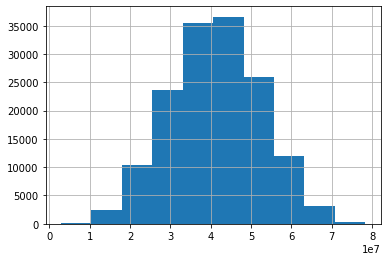

In [39]:
db['Total UL (Bytes)'].hist() #skewness of Total upload column

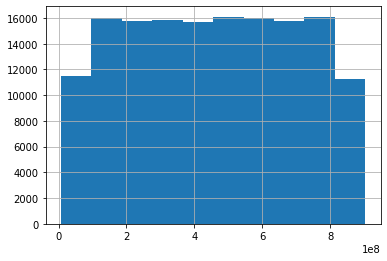

In [40]:
db['Total DL (Bytes)'].hist()

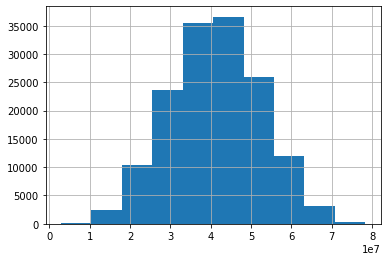

In [41]:
db['Total UL (Bytes)'].hist()

### Positively skewed parameter

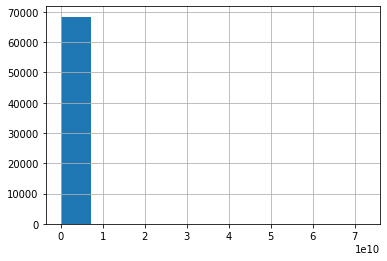

In [42]:
db['HTTP DL (Bytes)'].hist()

### Negatively skewwed parameter


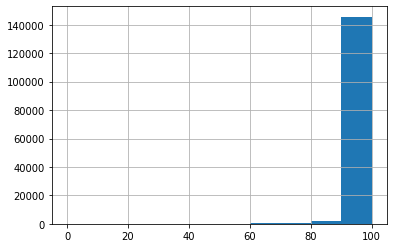

In [43]:
db['UL TP < 10 Kbps (%)'].hist()

### Data with total missing values in each column - revisited

In [44]:
db.isna().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

### Column data types - revisited

In [45]:
db.dtypes

Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mb

### Utility function to fill missing values
* numeric missing values with mean method
* object type missing values with mode method

In [46]:
# fill numeric columns with ffill and bfill
"""
df[col].fillna(method='ffill') and df[col].fillna(method='bfill') or 
df[col].ffill(axis = 0) and df[col].bfill(axis = 0) fills the missing values with the value before/after it
"""
# fill missing numeric values with mean and object type values with mode
def fill_missing_values(df):
  for column in df.columns:
    if df[column].dtype == 'float64':
      df[column] = df[column].fillna(df[column].mean())
    elif df[column].dtypes == 'object':
      df[column] = df[column].fillna(df[column].mode()[0])
  return df


### Data with all missing values filled - zero null count



In [47]:
fill_missing_values(db).isna().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

### Other method of handling missing values - Interpolation
* We can use interpolation while working with time-series data because in time-series data we like to fill missing values with previous one or two values.
* It can be used to estimate unknown data points between two known data points.

##### Since we are not considering the time-series nature of the telecom data, we choose not to use interpolation here.

In [48]:
# db.interpolate(inplace=True)

## Data Transformation

**Scaling and Normalization**

##### Scaling - changing the range of your data 
##### Normalization, you're changing the shape of the distribution of your data.

#### Scaling

* This transforms data so that it fits within a specific scale, like 0-100 or 0-1. 
* It is important when we're using methods based on distance measures of data points like support vector machines (SVM) or k-nearest neighbors (KNN).
* We use the scaler method from sklearn.

#### Normalization

Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

* Normal distribution ("bell curve", Gaussian distribution) is a specific statistical distribution where a roughly equal observations fall above and below the mean
 * The mean and the median are the same, and there are more observations closer to the mean.

* In general, you'll normalize your data if you're going to be using a machine learning or statistics technique like LDA and Gaussian naive Bayes that assumes your data is normally distributed. Some examples of these include linear discriminant analysis (LDA) and Gaussian naive Bayes. (Pro tip: any method with "Gaussian" in the name probably assumes normality.)

* We usee the Normalizer method from sklearn



### Numeric value scalling

In [49]:
minmax_scaler = preprocessing.MinMaxScaler()
def scalling_numeric_values(df):
  col_values = []
  for column in df.columns:
    if df[column].dtype == 'float64':
      col_values.append(list(df[column].values))
  col_values_skaled = minmax_scaler.fit_transform(col_values)
  db_scaled = pd.DataFrame(col_values_skaled)
  return df



In [50]:
db_sklearn = fill_missing_values(db.copy())
scalling_numeric_values(db_sklearn)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,"13,114,483,460,844,900,352.00",4/4/2019 12:01,770.00,4/25/2019 14:35,662.00,"1,823,652.00","208,201,448,079,117.00","33,664,962,239.00","35,521,209,507,511.00",9.16456699548519E+015,42.00,5.00,23.00,44.00,"20,809,914.27","759,658.66",100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"114,471,023.70","3,242,301.38","37,624.00","38,787.00","1,823,652,892.00",Samsung,Samsung Galaxy A5 Sm-A520F,989.70,340.43,810.84,149.26,965.46,141.30,213.00,214.00,"1,545,765.00","24,420.00","1,634,479.00","1,271,433.00","3,563,542.00","137,762.00","15,854,611.00","2,501,332.00","8,198,936.00","9,656,251.00","278,082,303.00","14,344,150.00","171,744,450.00","8,814,393.00","36,749,741.00","308,879,636.00"
1,"13,114,483,482,878,900,224.00",4/9/2019 13:04,235.00,4/25/2019 8:15,606.00,"1,365,104.00","208,201,909,211,140.00","33,681,854,413.00","35,794,009,006,359.00",L77566A,65.00,5.00,16.00,26.00,"20,809,914.27","759,658.66",100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"114,471,023.70","3,242,301.38",168.00,"3,560.00","1,365,104,371.00",Samsung,Samsung Galaxy J5 (Sm-J530),989.70,340.43,810.84,149.26,965.46,141.30,971.00,"1,022.00","1,926,113.00","7,165.00","3,493,924.00","920,172.00","629,046.00","308,339.00","20,247,395.00","19,111,729.00","18,338,413.00","17,227,132.00","608,750,074.00","1,170,709.00","526,904,238.00","15,055,145.00","53,800,391.00","653,384,965.00"
2,"13,114,483,484,080,500,736.00",4/9/2019 17:42,1.00,4/25/2019 11:58,652.00,"1,361,762.00","208,200,314,458,056.00","33,760,627,129.00","35,281,510,359,387.00",D42335A,109.80,17.66,6.00,9.00,"20,809,914.27","759,658.66",100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"114,471,023.70","3,242,301.38",0.00,0.00,"1,361,762,651.00",Samsung,Samsung Galaxy A8 (2018),989.70,340.43,810.84,149.26,965.46,141.30,751.00,695.00,"1,684,053.00","42,224.00","8,535,055.00","1,694,064.00","2,690,151.00","672,973.00","19,725,661.00","14,699,576.00","17,587,794.00","6,163,408.00","229,584,621.00","395,630.00","410,692,588.00","4,215,763.00","27,883,638.00","279,807,335.00"
3,"13,114,483,485,442,799,616.00",4/10/2019 0:31,486.00,4/25/2019 7:36,171.00,"1,321,509.00","208,201,402,342,131.00","33,750,343,200.00","35,356,610,164,913.00",T21824A,109.80,17.66,44.00,44.00,"20,809,914.27","759,658.66",100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"114,471,023.70","3,242,301.38","3,330.00","37,882.00","1,321,509,685.00",Apple,Huawei B528S-23A,989.70,340.43,810.84,149.26,965.46,141.30,17.00,207.00,"644,121.00","13,372.00","9,023,734.00","2,788,027.00","1,439,754.00","631,229.00","21,388,122.00","15,146,643.00","13,994,646.00","1,097,942.00","799,538,153.00","10,849,722.00","749,039,933.00","12,797,283.00","43,324,218.00","846,028,530.00"
4,"13,114,483,499,480,700,928.00",4/12/2019 20:10,565.00,4/25/2019 10:40,954.00,"1,089,009.00","208,201,401,415,120.00","33,699,795,932.00","35,407,009,745,539.00",D88865A,109.8

### Scaling between [0,1]

In [51]:
def scalling_numeric_values_0_1(df):
  for column in df.columns:
    if df[column].dtype == 'float64':
      df[column] = MinMaxScaler().fit_transform(np.array(df[column]).reshape(150001,1))
  return df

In [52]:
db_sklearn = fill_missing_values(db.copy())
scalling_numeric_values_0_1(db_sklearn)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,0.99,4/4/2019 12:01,0.77,4/25/2019 14:35,0.66,0.98,0.41,0.00,0.36,9.16456699548519E+015,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,Samsung,Samsung Galaxy A5 Sm-A520F,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.43,0.37,0.14,0.31,0.99,0.15,0.68,0.11,0.35,0.44,0.33,0.87,0.20,0.53,0.45,0.34
1,0.99,4/9/2019 13:04,0.24,4/25/2019 8:15,0.61,0.73,0.41,0.00,0.36,L77566A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.73,Samsung,Samsung Galaxy J5 (Sm-J530),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.54,0.11,0.30,0.22,0.18,0.33,0.87,0.87,0.79,0.78,0.72,0.07,0.62,0.91,0.67,0.72
2,0.99,4/9/2019 17:42,0.00,4/25/2019 11:58,0.65,0.73,0.41,0.00,0.35,D42335A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.73,Samsung,Samsung Galaxy A8 (2018),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.47,0.64,0.74,0.41,0.75,0.72,0.85,0.67,0.76,0.28,0.27,0.02,0.49,0.25,0.33,0.30
3,0.99,4/10/2019 0:31,0.49,4/25/2019 7:36,0.17,0.71,0.41,0.00,0.35,T21824A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71,Apple,Huawei B528S-23A,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.18,0.20,0.79,0.68,0.40,0.67,0.92,0.69,0.60,0.05,0.95,0.66,0.89,0.77,0.54,0.94
4,0.99,4/12/2019 20:10,0.57,4/25/2019 10:40,0.95,0.58,0.41,0.00,0.35,D88865A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.58,Samsung,Samsung Sm-G390F,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.24,0.76,0.55,0.36,0.54,0.19,0.66,0.86,0.74,0.02,0.63,0.21,0.65,0.84,0.47,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0.06,4/29/2019 7:28,0.45,4/30/2019 6:02,0.21,0.04,0.41,0.00,0.36,D20434A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,Apple,Apple iPhone 8 Plus (A1897),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.97,0.79,0.87,0.68,0.02,0.68,0.70,0.53,0.77,0.89,0.62,0.56,0.00,0.81,0.73,0.63
149997,0.07,4/29/2019 7:28,0.48,4/30/2019 10:41,0.19,0.05,0.41,0.00,0.36,D10223C,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,Apple,Apple iPhone Se (A1723),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.65,0.12,0.19,0.53,0.54,0.18,0.60,0.38,0.83,0.97,0.74,0.29,0.84,0.15,0.48,0.74
149998,0.99,4/29/2019 7:28,0.28,4/30/2019 10:46,0.81,0.05,0.41,0.00,0.36,T51102A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,Apple,Apple iPhone Xs (A2097),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.35,0.22,0.34,0.66,0.43,0.57,0.97,0.08,0.43,0.23,0.66,0.81,0.14,0.68,0.42,0.65
149999,0.99,4/29/2019 7:28,0.70,4/30/20

### Min values in each column

In [53]:
db.min()

Bearer Id                                              6,917,537,518,543,529,984.00
Start                                                                4/10/2019 0:31
Start ms                                                                       0.00
End                                                                 4/24/2019 22:59
End ms                                                                         0.00
Dur. (ms)                                                                  7,142.00
IMSI                                                         204,047,108,489,451.00
MSISDN/Number                                                     33,601,001,722.00
IMEI                                                             440,015,202,000.00
Last Location Name                                            1.53279754934046E+017
Avg RTT DL (ms)                                                                0.00
Avg RTT UL (ms)                                                             

### Max values in each column

In [54]:
db.max()

Bearer Id                                     13,186,541,167,134,199,808.00
Start                                                         4/9/2019 9:47
Start ms                                                             999.00
End                                                          4/30/2019 9:59
End ms                                                               999.00
Dur. (ms)                                                      1,859,336.00
IMSI                                                 214,074,303,349,628.00
MSISDN/Number                                        882,397,108,489,451.00
IMEI                                                  99,001,201,327,774.00
Last Location Name                                                  Y72157C
Avg RTT DL (ms)                                                   96,923.00
Avg RTT UL (ms)                                                    7,120.00
Avg Bearer TP DL (kbps)                                          378,160.00
Avg Bearer T

### Data Extraction

In [55]:
db['MSISDN/Number'].value_counts()

41,882,819,545.03    1066
33,626,320,676.00      18
33,614,892,860.00      17
33,625,779,332.00      17
33,659,725,664.00      16
                     ... 
33,664,955,942.00       1
33,663,469,453.00       1
33,665,287,654.00       1
33,659,372,298.00       1
33,619,622,058.00       1
Name: MSISDN/Number, Length: 106857, dtype: int64

In [56]:
db['Dur. (ms)'].value_counts()

86,399.00     21413
86,400.00      6437
85,499.00       188
86,398.00       145
86,397.00       110
              ...  
171,697.00        1
180,450.00        1
176,343.00        1
180,189.00        1
104,608.56        1
Name: Dur. (ms), Length: 89526, dtype: int64

In [57]:
percent_missing(db)

The dataset contains 0.0 % missing values.


In [58]:
missing_values_table(db)

Your selected dataframe has 55 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,Dtype


### Mean and Mediam of some vital attributes

In [59]:
important_columns_numeric = ['Bearer Id','Dur. (ms)','MSISDN/Number',
                      'Avg RTT DL (ms)','Avg RTT UL (ms)',
                      'TCP DL Retrans. Vol (Bytes)','TCP UL Retrans. Vol (Bytes)',
                      'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                      'Google DL (Bytes)', 'Google UL (Bytes)', 
                      'Email DL (Bytes)','Email UL (Bytes)',
                      'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                      'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 
                      'Gaming DL (Bytes)','Gaming UL (Bytes)',
                      'Other DL (Bytes)', 'Other UL (Bytes)',
                      'Total UL (Bytes)', 'Total DL (Bytes)' ]

important_columns_object = ['Handset Manufacturer','Handset Type']
db[important_columns_numeric].mean() #mean of numeric columns

Bearer Id                     10,138,874,654,256,338,944.00
Dur. (ms)                                        104,608.56
MSISDN/Number                             41,882,819,545.03
Avg RTT DL (ms)                                      109.80
Avg RTT UL (ms)                                       17.66
TCP DL Retrans. Vol (Bytes)                   20,809,914.27
TCP UL Retrans. Vol (Bytes)                      759,658.66
Social Media DL (Bytes)                        1,795,321.77
Social Media UL (Bytes)                           32,928.43
Google DL (Bytes)                              5,750,752.62
Google UL (Bytes)                              2,056,541.93
Email DL (Bytes)                               1,791,728.87
Email UL (Bytes)                                 467,373.44
Youtube DL (Bytes)                            11,634,072.50
Youtube UL (Bytes)                            11,009,410.13
Netflix DL (Bytes)                            11,626,851.72
Netflix UL (Bytes)                      

In [60]:
db[important_columns_numeric].median()

Bearer Id                     7,349,883,264,196,119,552.00
Dur. (ms)                                        86,399.00
MSISDN/Number                            33,663,797,508.00
Avg RTT DL (ms)                                      54.00
Avg RTT UL (ms)                                       7.00
TCP DL Retrans. Vol (Bytes)                  20,809,914.27
TCP UL Retrans. Vol (Bytes)                     759,658.66
Social Media DL (Bytes)                       1,794,369.00
Social Media UL (Bytes)                          32,920.00
Google DL (Bytes)                             5,765,829.00
Google UL (Bytes)                             2,054,573.00
Email DL (Bytes)                              1,793,505.00
Email UL (Bytes)                                466,250.00
Youtube DL (Bytes)                           11,616,019.00
Youtube UL (Bytes)                           11,013,447.00
Netflix DL (Bytes)                           11,642,217.00
Netflix UL (Bytes)                           10,996,384.

In [61]:
db[important_columns_object].mode()

,Handset Manufacturer,Handset Type
0,Apple,Huawei B528S-23A


### Univariate analysis - Analysis using only one feature/variable

In [62]:
db_explore = db.copy()

In [63]:
fix_outlier(db_explore, "MSISDN/Number")

0        33,664,962,239.00
1        33,681,854,413.00
2        33,760,627,129.00
3        33,750,343,200.00
4        33,699,795,932.00
                ...       
149996   33,650,688,697.00
149997   33,663,449,963.00
149998   33,621,890,103.00
149999   33,619,622,058.00
150000   33,663,797,508.00
Name: MSISDN/Number, Length: 150001, dtype: float64

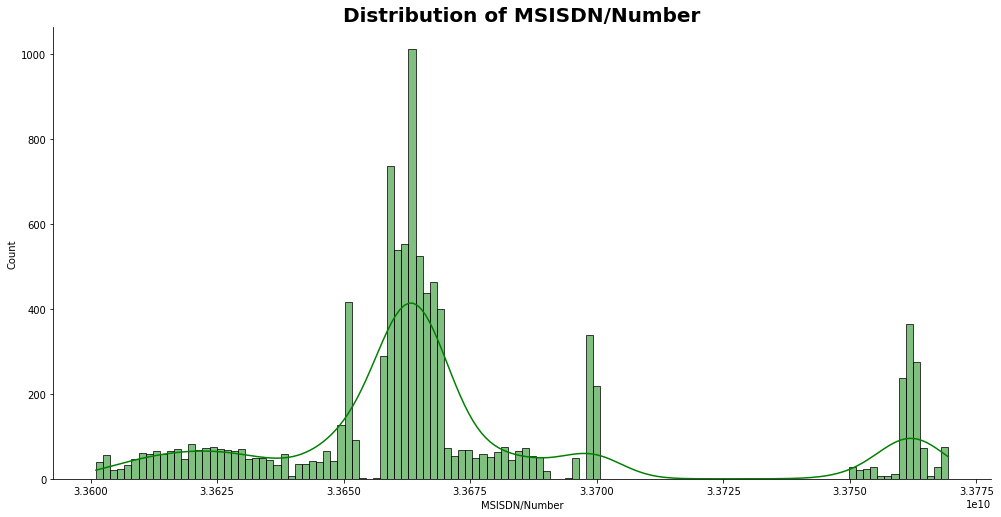

In [64]:
plot_hist(db_explore.head(10000),"MSISDN/Number" ,'green')

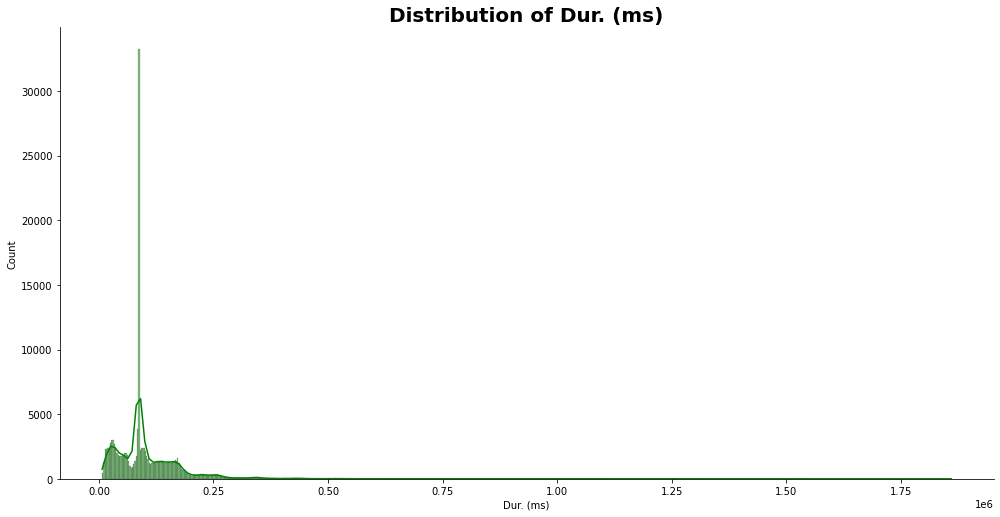

In [65]:
plot_hist(db_explore, "Dur. (ms)", "green")

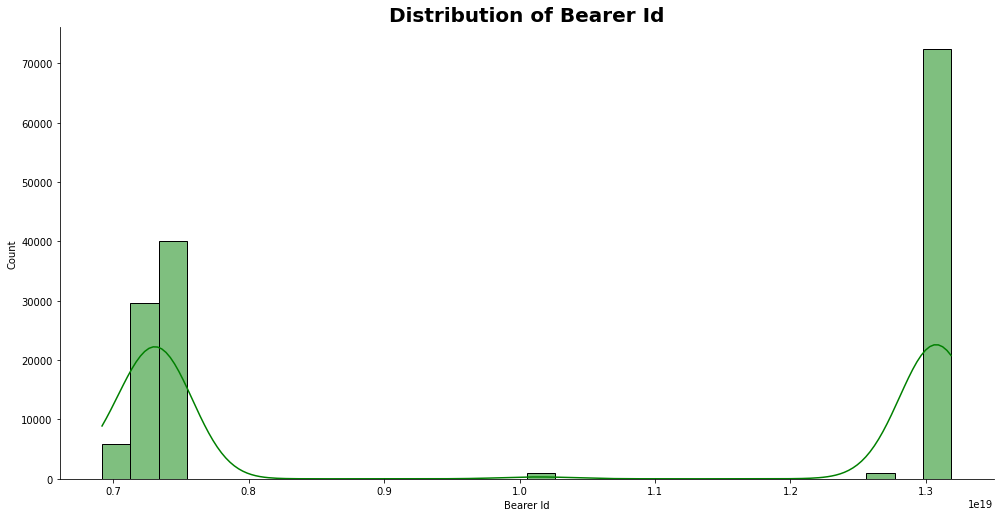

In [66]:
plot_hist(db_explore, "Bearer Id", "green")

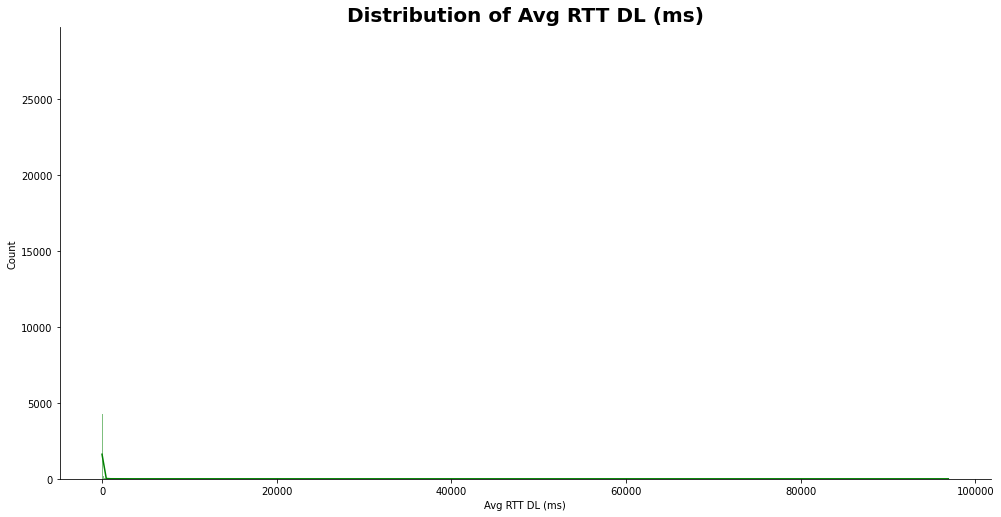

In [67]:
plot_hist(db_explore, "Avg RTT DL (ms)", "green")

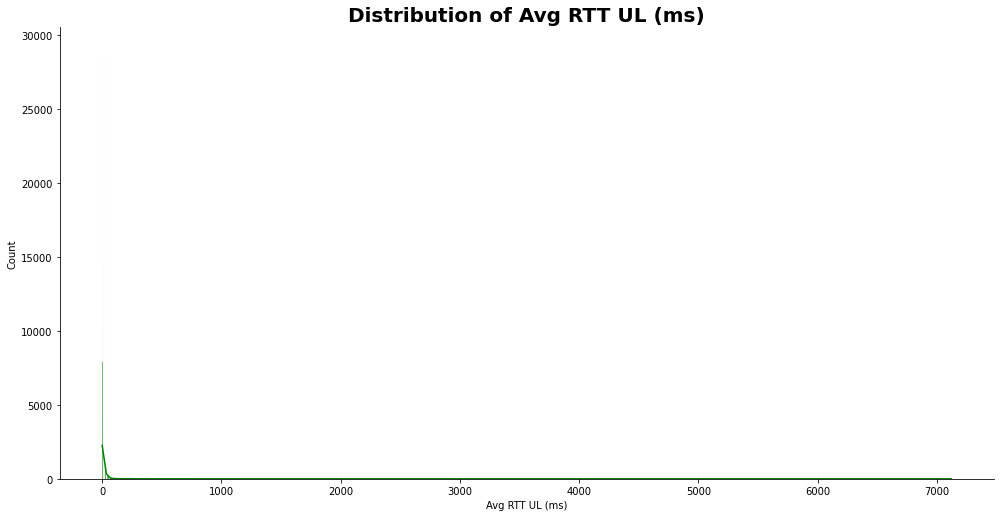

In [68]:
plot_hist(db_explore, "Avg RTT UL (ms)", "green")

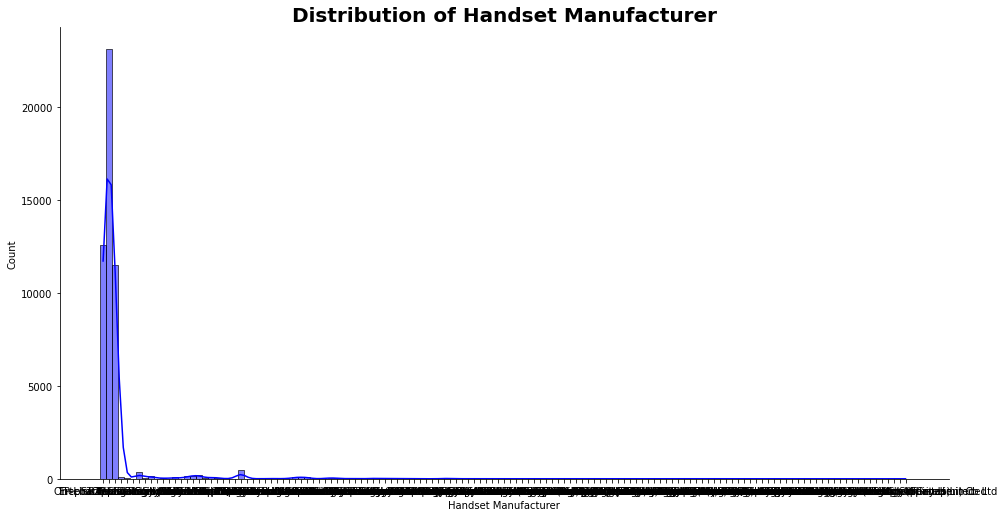

In [69]:
plot_hist(db_explore.head(50000), "Handset Manufacturer", "blue")

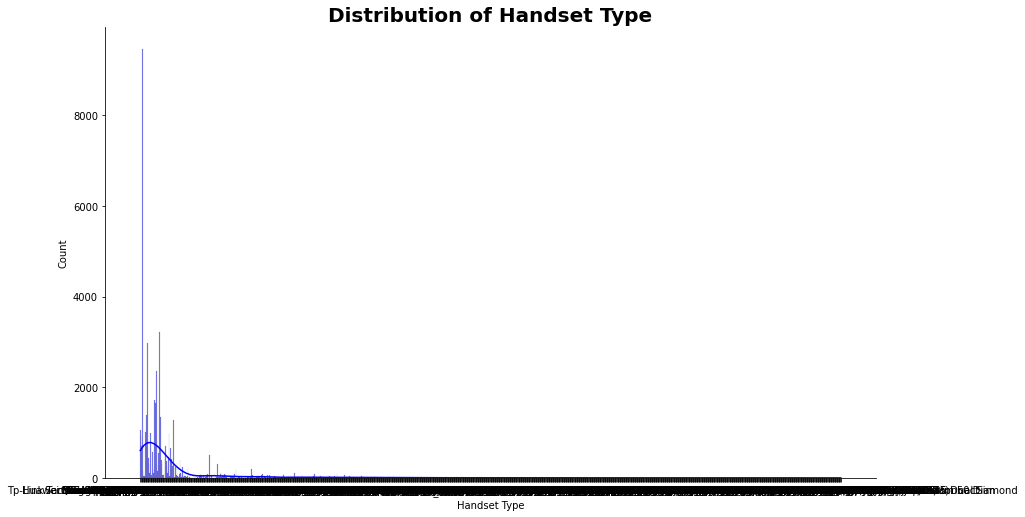

In [70]:
plot_hist(db_explore.head(50000), "Handset Type", "blue")

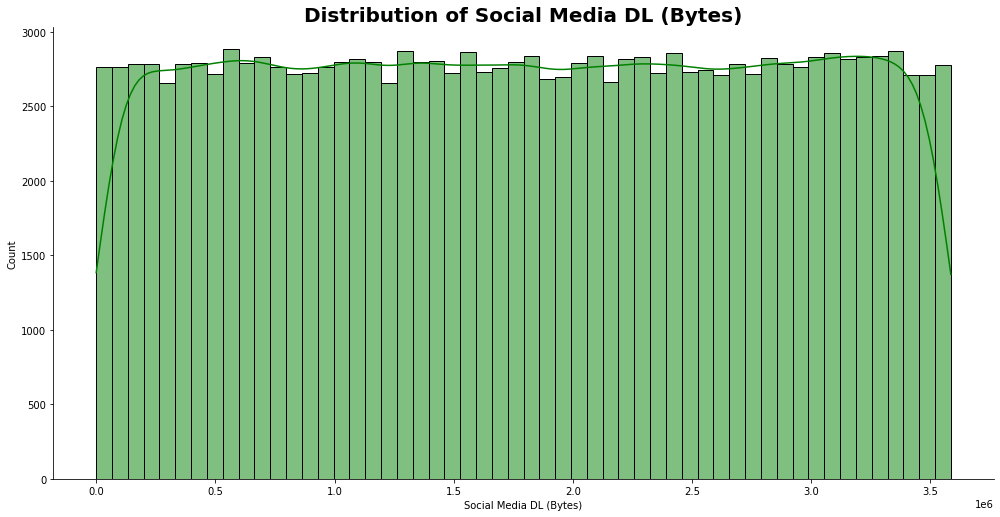

In [71]:
plot_hist(db_explore, "Social Media DL (Bytes)", "green")
# sns.histplot(x=columns[0], data =db) # this also works

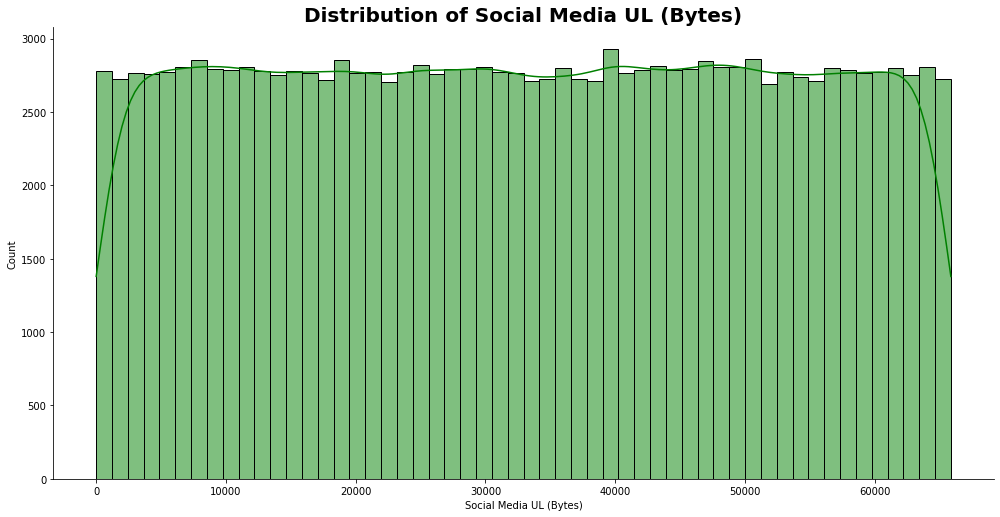

In [72]:
plot_hist(db_explore, "Social Media UL (Bytes)", "green")

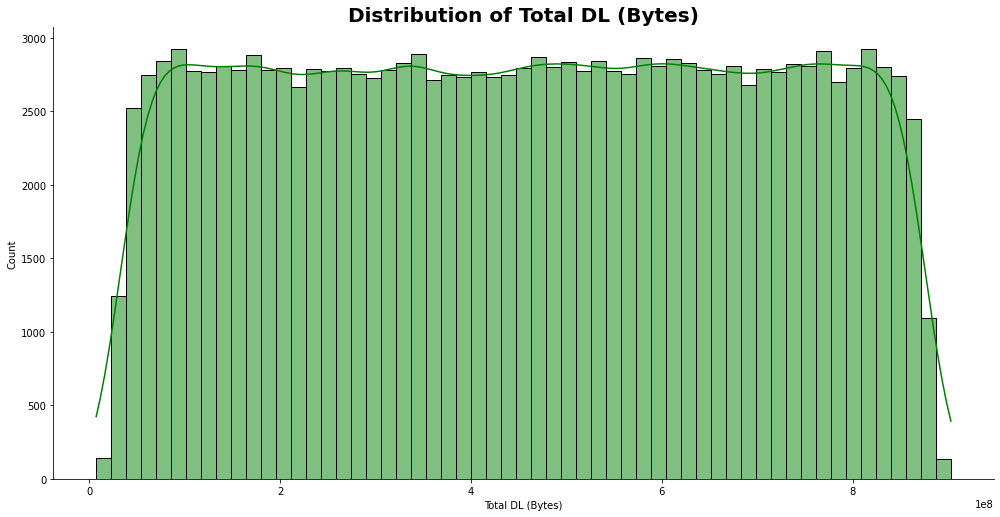

In [73]:
plot_hist(db_explore, "Total DL (Bytes)", "green")

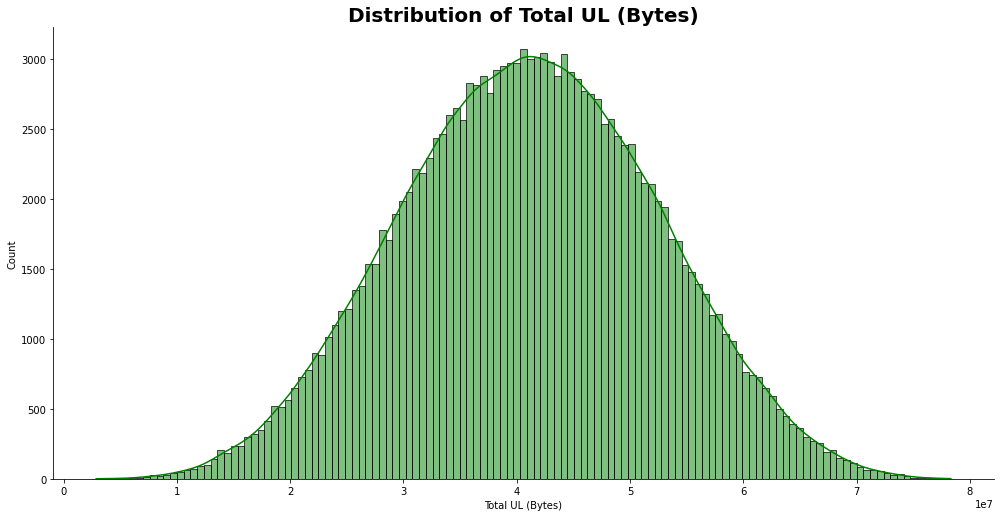

In [74]:
plot_hist(db_explore, "Total UL (Bytes)", "green")

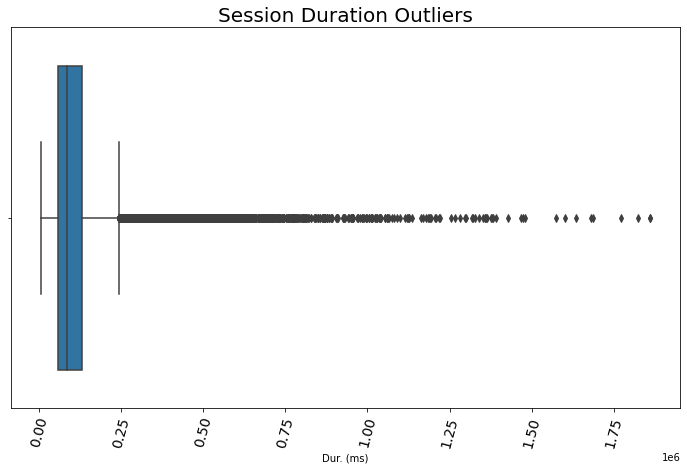

In [75]:
plot_box(db_explore, "Dur. (ms)", "Session Duration Outliers")

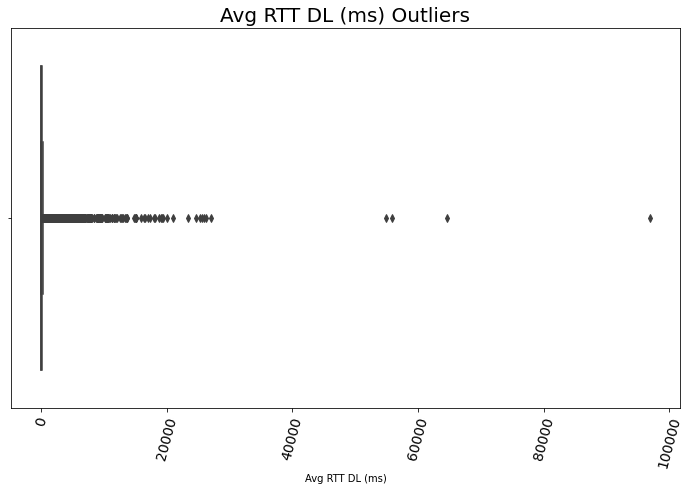

In [76]:
plot_box(db_explore, "Avg RTT DL (ms)", "Avg RTT DL (ms) Outliers")

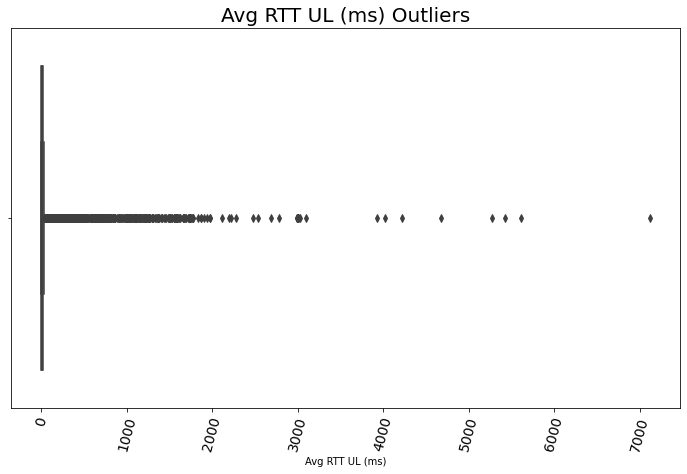

In [77]:
plot_box(db_explore, "Avg RTT UL (ms)", "Avg RTT UL (ms) Outliers")

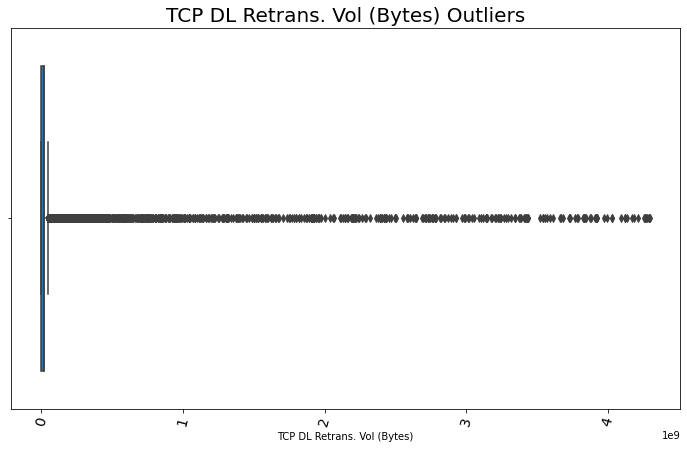

In [78]:
plot_box(db_explore, "TCP DL Retrans. Vol (Bytes)", "TCP DL Retrans. Vol (Bytes) Outliers")

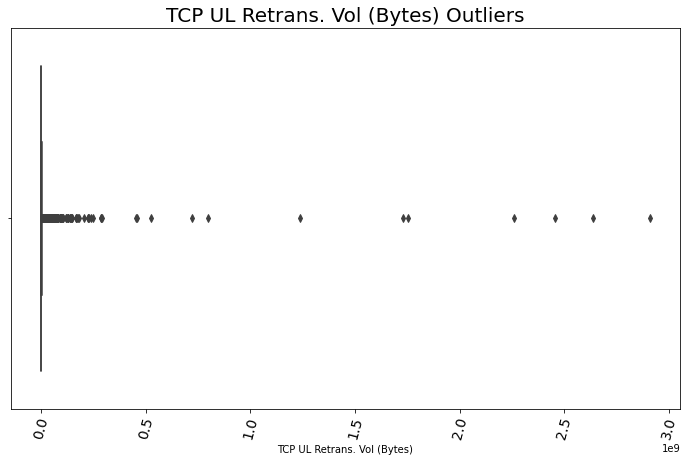

In [79]:
plot_box(db_explore, "TCP UL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes) Outliers")

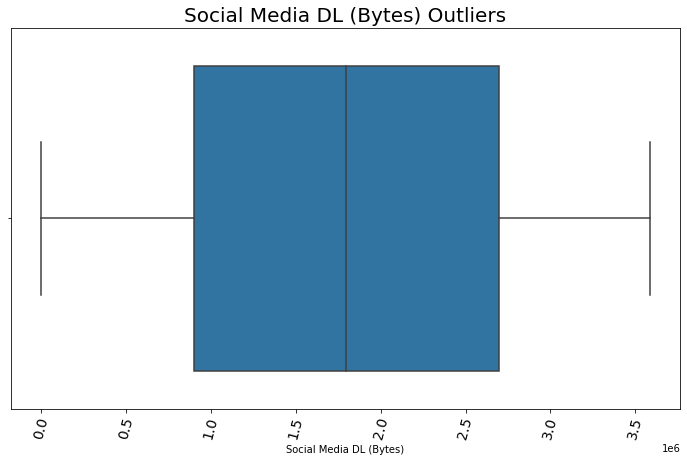

In [80]:
plot_box(db_explore, "Social Media DL (Bytes)", "Social Media DL (Bytes) Outliers")

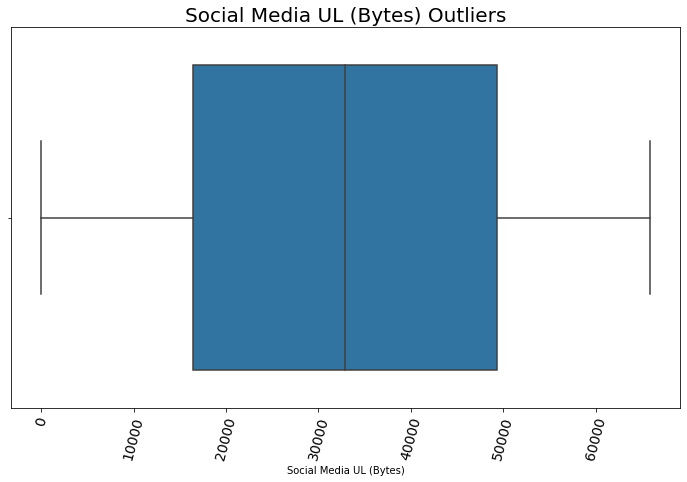

In [81]:
plot_box(db_explore, "Social Media UL (Bytes)", "Social Media UL (Bytes) Outliers")

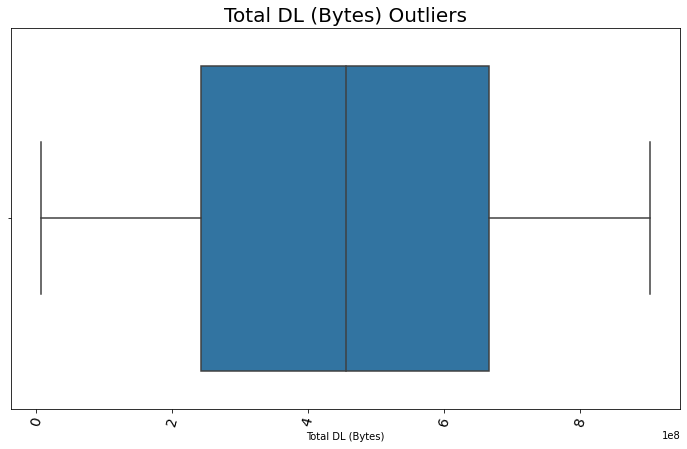

In [82]:
plot_box(db_explore, "Total DL (Bytes)", "Total DL (Bytes) Outliers")

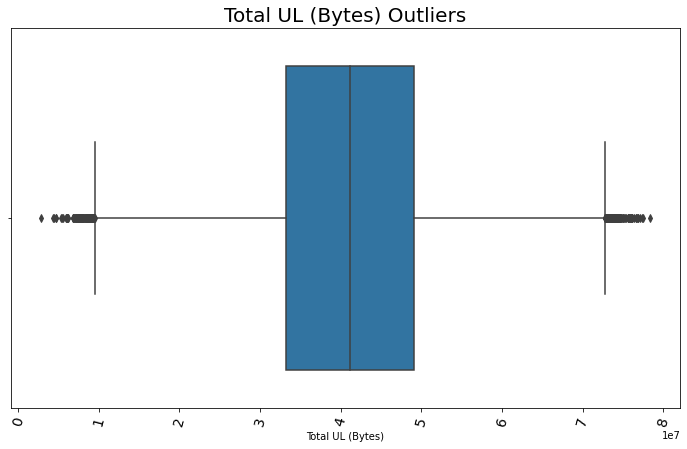

In [83]:
plot_box(db_explore, "Total UL (Bytes)", "Total UL (Bytes) Outliers")

### Categorical Data Plot

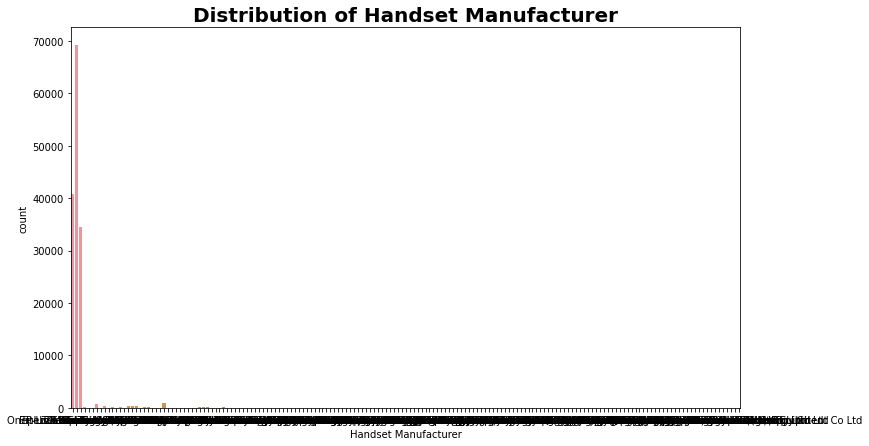

In [84]:
plot_count(db_explore, "Handset Manufacturer")

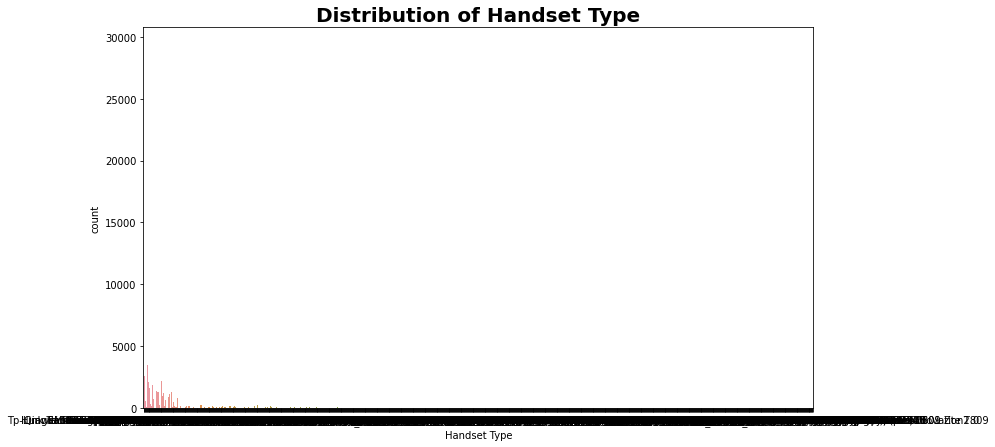

In [85]:
plot_count(db_explore, "Handset Type")

### Non-graphical Univariat EDA

In [86]:
db.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,"150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00","150,001.00"
mean,"10,138,874,654,256,338,944.00",499.19,498.80,"104,608.56","208,201,639,651,669.06","41,882,819,545.03","48,474,547,977,654.55",109.80,17.66,"13,300.05","1,770.43","20,809,914.27","759,658.66",92.84,3.07,1.72,1.61,98.53,0.78,0.15,0.08,"114,471,023.70","3,242,301.38","1,829,176.87","1,408,879.97","104,609,105.55",989.70,340.43,810.84,149.26,965.46,141.30,"3,719.79","4,022.08","1,795,321.77","32,928.43","5,750,752.62","2,056,541.93","1,791,728.87","467,373.44","11,634,072.50","11,009,410.13","11,626,851.72","11,001,754.82","422,044,702.60","8,288,398.11","421,100,544.19","8,264,799.42","41,121,206.29","454,643,430.08"
std,"2,883,599,561,544,278,016.00",288.61,288.10,"81,037.35","21,447,224,608.89","2,438,731,270,479.18","22,373,590,654,759.21",559.34,76.53,"23,971.80","4,625.34","117,235,576.02","15,776,162.06",13.01,6.20,4.15,4.82,4.62,3.22,1.62,1.29,"651,022,628.64","13,195,316.58","5,696,376.48","4,643,215.12","81,037,341.45","1,506.00",891.81,"1,129.73",442.32,"1,248.15",501.01,"9,148.50","10,133.43","1,035,482.28","19,006.18","3,309,097.02","1,189,916.93","1,035,839.51","269,969.31","6,710,568.85","6,345,423.35","6,725,218.03","6,359,489.76","243,967,494.35","4,782,699.66","243,205,009.81","4,769,003.69","11,276,348.93","244,142,060.57"
min,"6,917,537,518,543,529,984.00",0.00,0.00,"7,142.00","204,047,108,489,451.00","33,601,001,722.00","440,015,202,000.00",0.00,0.00,0.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,40.00,40.00,0.00,0.00,"7,142,988.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,12.00,0.00,207.00,3.00,14.00,2.00,53.00,105.00,42.00,35.00,"2,516.00",59.00,"3,290.00",148.00,"2,866,892.00","7,114,041.00"
25%,"7,349,883,247,447,919,616.00",250.00,251.00,"57,442.00","208,201,401,264,956.00","33,651,508,781.00","35,462,609,538,986.00",35.00,3.00,43.00,47.00,"1,332,932.00","63,009.00",91.00,0.00,0.00,0.00,99.00,0.00,0.00,0.00,"3,028,893.00","336,016.00","14,878.00","21,540.00","57,442,058.00",533.00,121.00,453.00,149.26,527.00,141.30,88.00,107.00,"899,148.00","16,448.00","2,882,393.00","1,024,279.00","892,793.00","233,383.00","5,833,501.00","5,517,965.00","5,777,156.00","5,475,981.00","210,473,253.00","4,128,476.00","210,186,872.00","4,145,943.00","33,222,029.00","243,107,173.00"
50%,"7,349,883,264,196,119,552

In [87]:
db["Total DL (Bytes)"].describe()

count       150,001.00
mean    454,643,430.08
std     244,142,060.57
min       7,114,041.00
25%     243,107,173.00
50%     455,840,911.00
75%     665,705,138.00
max     902,969,616.00
Name: Total DL (Bytes), dtype: float64

In [88]:
db["Total UL (Bytes)"].describe()

count      150,001.00
mean    41,121,206.29
std     11,276,348.93
min      2,866,892.00
25%     33,222,029.00
50%     41,143,242.00
75%     49,034,238.00
max     78,331,311.00
Name: Total UL (Bytes), dtype: float64

In [89]:
db["MSISDN/Number"].describe()

count               150,001.00
mean         41,882,819,545.03
std       2,438,731,270,479.18
min          33,601,001,722.00
25%          33,651,508,781.00
50%          33,663,797,508.00
75%          33,684,730,950.00
max     882,397,108,489,451.00
Name: MSISDN/Number, dtype: float64

In [90]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 150001 non-null  float64
 1   Start                                     150001 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150001 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      150001 non-null  float64
 7   MSISDN/Number                             150001 non-null  float64
 8   IMEI                                      150001 non-null  float64
 9   Last Location Name                        150001 non-null  object 
 10  Avg RTT DL (ms)     

In [91]:
db.isna().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [92]:
# sns.histplot(x=db[columns]['Total UL (Bytes)'], data =db)

In [93]:
# sns.histplot(x=db[columns]['Total DL (Bytes)'], data =db)

### Bivariate analysis
#### Applications Vs Total DL and Total UL

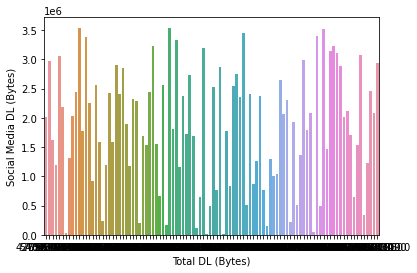

In [94]:
db_explore_100 = db_explore.head(100)
sns.barplot(x='Total DL (Bytes)',y='Social Media DL (Bytes)',data=db_explore_100)
# sns.countplot(x='Total DL (Bytes)',data=db) 
#boxplot, violinplot, stripplot, swarmplot, barplot also works

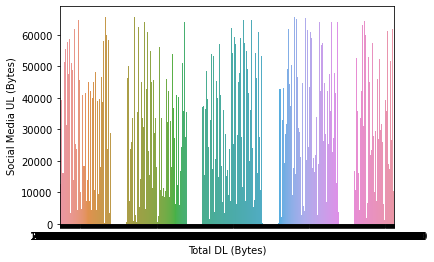

In [95]:
sns.barplot(x='Total DL (Bytes)',y='Social Media UL (Bytes)',data=db_explore.head(1000))

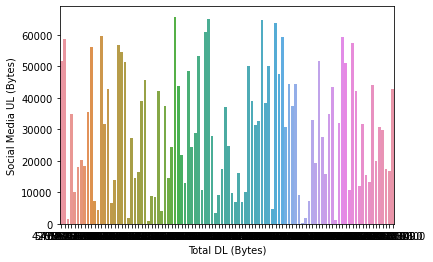

In [97]:
sns.barplot(x='Total DL (Bytes)',y='Social Media UL (Bytes)',data=db_explore_100)

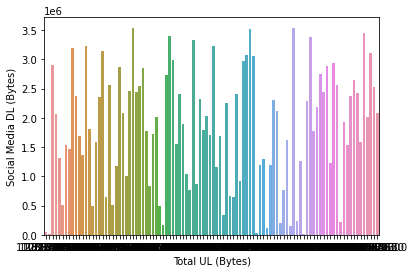

In [98]:
sns.barplot(x='Total UL (Bytes)',y='Social Media DL (Bytes)',data=db_explore_100)

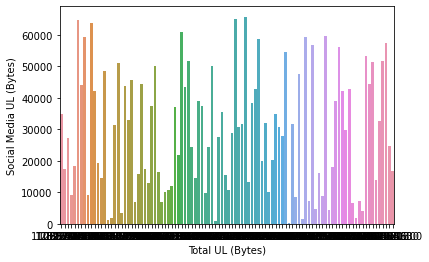

In [99]:
sns.barplot(x='Total UL (Bytes)',y='Social Media UL (Bytes)',data=db_explore_100)

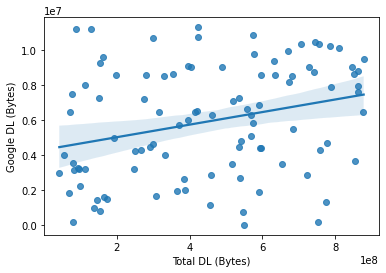

In [100]:
sns.regplot(x='Total DL (Bytes)',y='Google DL (Bytes)',data=db_explore_100)

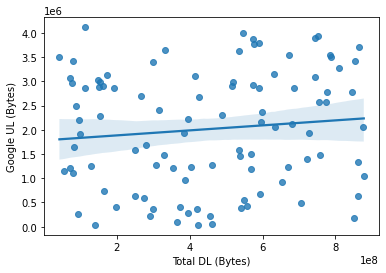

In [101]:
sns.regplot(x='Total DL (Bytes)',y='Google UL (Bytes)',data=db_explore_100)

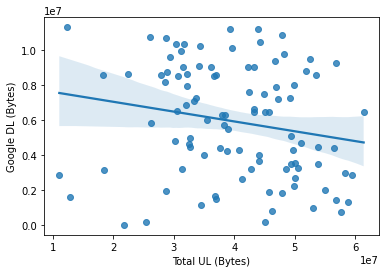

In [102]:
sns.regplot(x='Total UL (Bytes)',y='Google DL (Bytes)',data=db_explore_100)

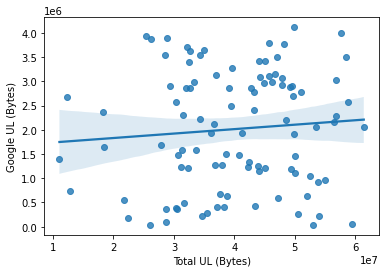

In [103]:
sns.regplot(x='Total UL (Bytes)',y='Google UL (Bytes)',data=db_explore_100)

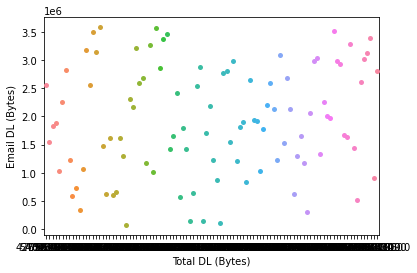

In [104]:
sns.stripplot(x='Total DL (Bytes)',y='Email DL (Bytes)',data=db_explore_100)

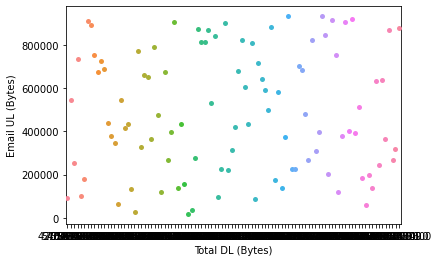

In [105]:
sns.stripplot(x='Total DL (Bytes)',y='Email UL (Bytes)',data=db_explore_100)

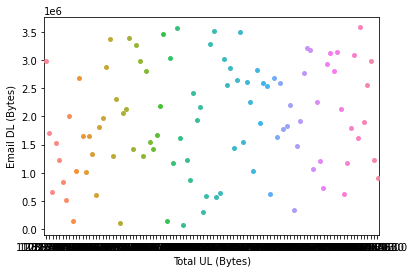

In [106]:
sns.stripplot(x='Total UL (Bytes)',y='Email DL (Bytes)',data=db_explore_100)

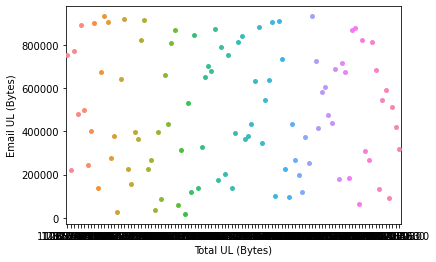

In [107]:
sns.stripplot(x='Total UL (Bytes)',y='Email UL (Bytes)',data=db_explore_100)

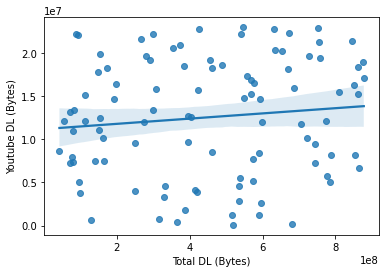

In [108]:
sns.regplot(x='Total DL (Bytes)',y='Youtube DL (Bytes)',data=db_explore_100)

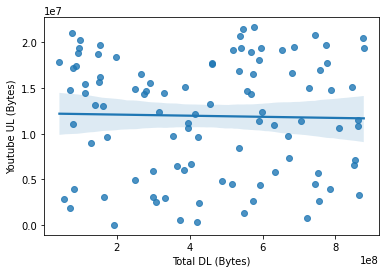

In [109]:
sns.regplot(x='Total DL (Bytes)',y='Youtube UL (Bytes)',data=db_explore_100)

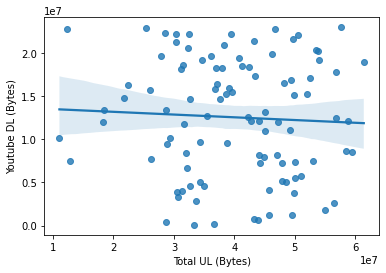

In [110]:
sns.regplot(x='Total UL (Bytes)',y='Youtube DL (Bytes)',data=db_explore_100)

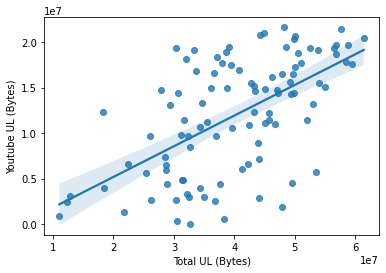

In [111]:
sns.regplot(x='Total UL (Bytes)',y='Youtube UL (Bytes)',data=db_explore_100)

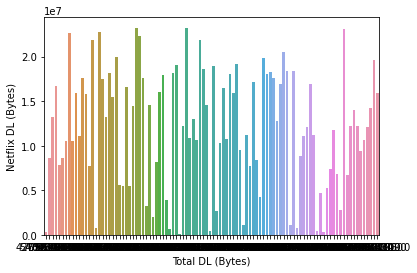

In [112]:
sns.barplot(x='Total DL (Bytes)',y='Netflix DL (Bytes)',data=db_explore_100)

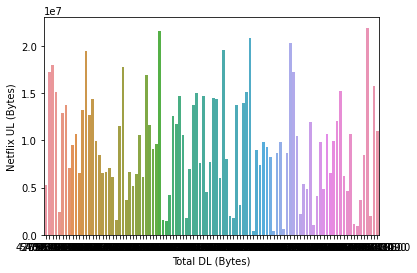

In [113]:
sns.barplot(x='Total DL (Bytes)',y='Netflix UL (Bytes)',data=db_explore_100)

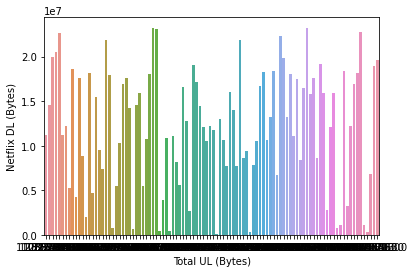

In [114]:
sns.barplot(x='Total UL (Bytes)',y='Netflix DL (Bytes)',data=db_explore_100)

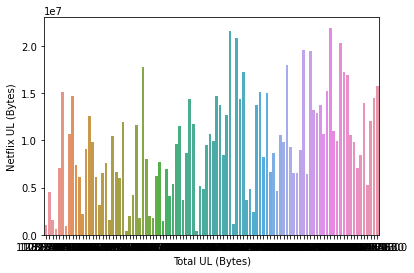

In [115]:
sns.barplot(x='Total UL (Bytes)',y='Netflix UL (Bytes)',data=db_explore_100)

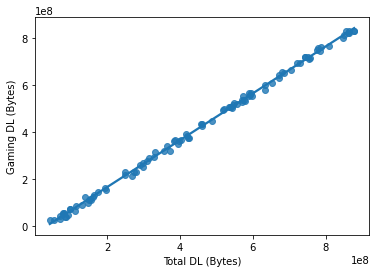

In [116]:
sns.regplot(x='Total DL (Bytes)',y='Gaming DL (Bytes)',data=db_explore_100)

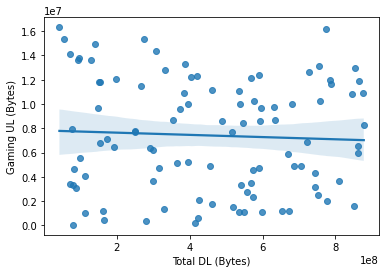

In [117]:
sns.regplot(x='Total DL (Bytes)',y='Gaming UL (Bytes)',data=db_explore_100)

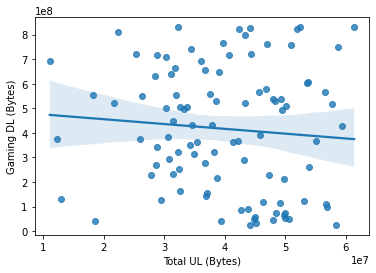

In [118]:
sns.regplot(x='Total UL (Bytes)',y='Gaming DL (Bytes)',data=db_explore_100)

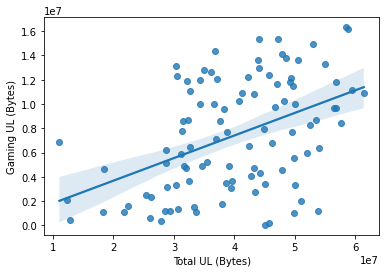

In [119]:
sns.regplot(x='Total UL (Bytes)',y='Gaming UL (Bytes)',data=db_explore_100)

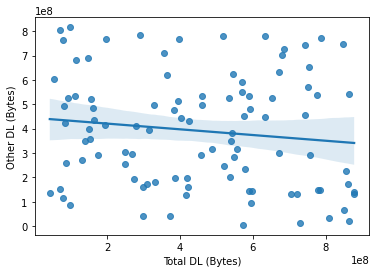

In [120]:
sns.regplot(x='Total DL (Bytes)',y='Other DL (Bytes)',data=db_explore_100)

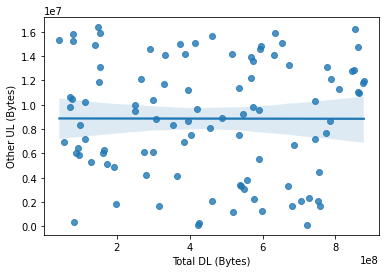

In [121]:
sns.regplot(x='Total DL (Bytes)',y='Other UL (Bytes)',data=db_explore_100)

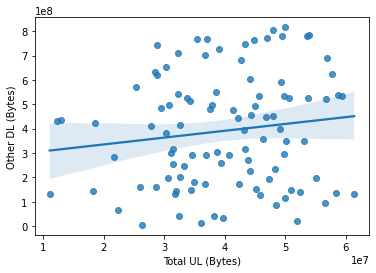

In [122]:
sns.regplot(x='Total UL (Bytes)',y='Other DL (Bytes)',data=db_explore_100)

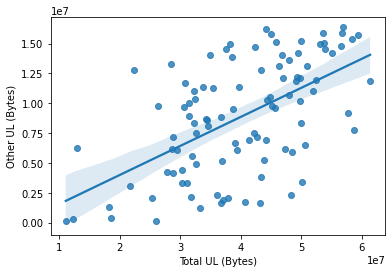

In [123]:
sns.regplot(x='Total UL (Bytes)',y='Other UL (Bytes)',data=db_explore_100)

### Multivariate Analysis

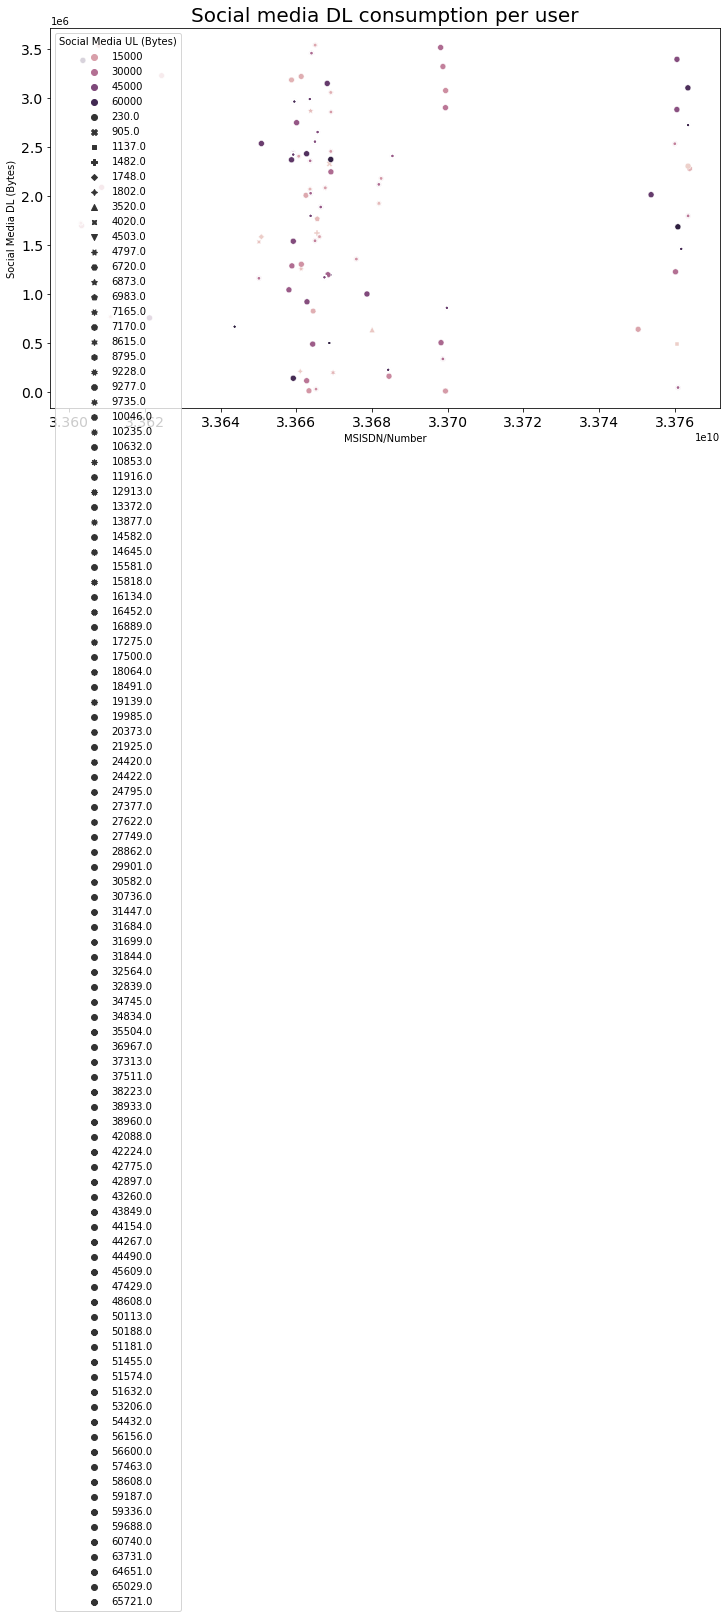

In [124]:
plot_scatter(db_explore.head(100), x_col="MSISDN/Number", y_col="Social Media DL (Bytes)", hue="Social Media UL (Bytes)",
             style="Social Media UL (Bytes)", title="Social media DL consumption per user")

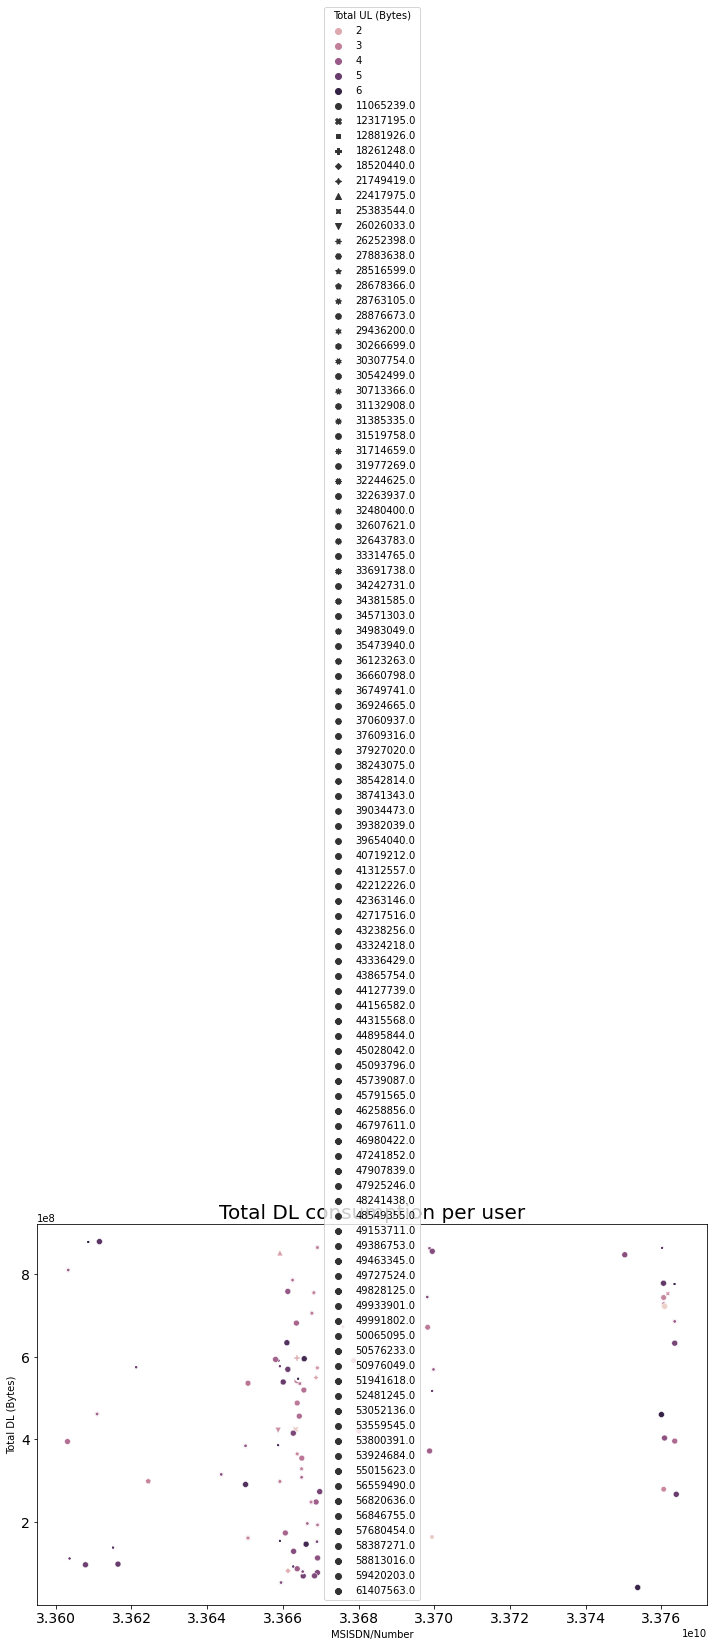

In [136]:
plot_scatter(db_explore.head(100), x_col="MSISDN/Number", y_col="Total DL (Bytes)", hue="Total UL (Bytes)",
             style="Total UL (Bytes)", title="Total DL consumption per user")

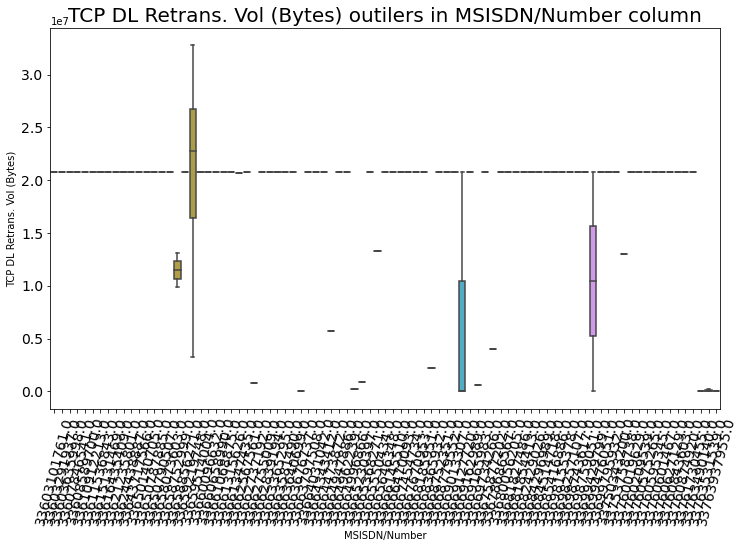

In [126]:
plot_box_multi(db_explore.head(100), x_col="MSISDN/Number", y_col="TCP DL Retrans. Vol (Bytes)", 
               title="TCP DL Retrans. Vol (Bytes) outilers in MSISDN/Number column")

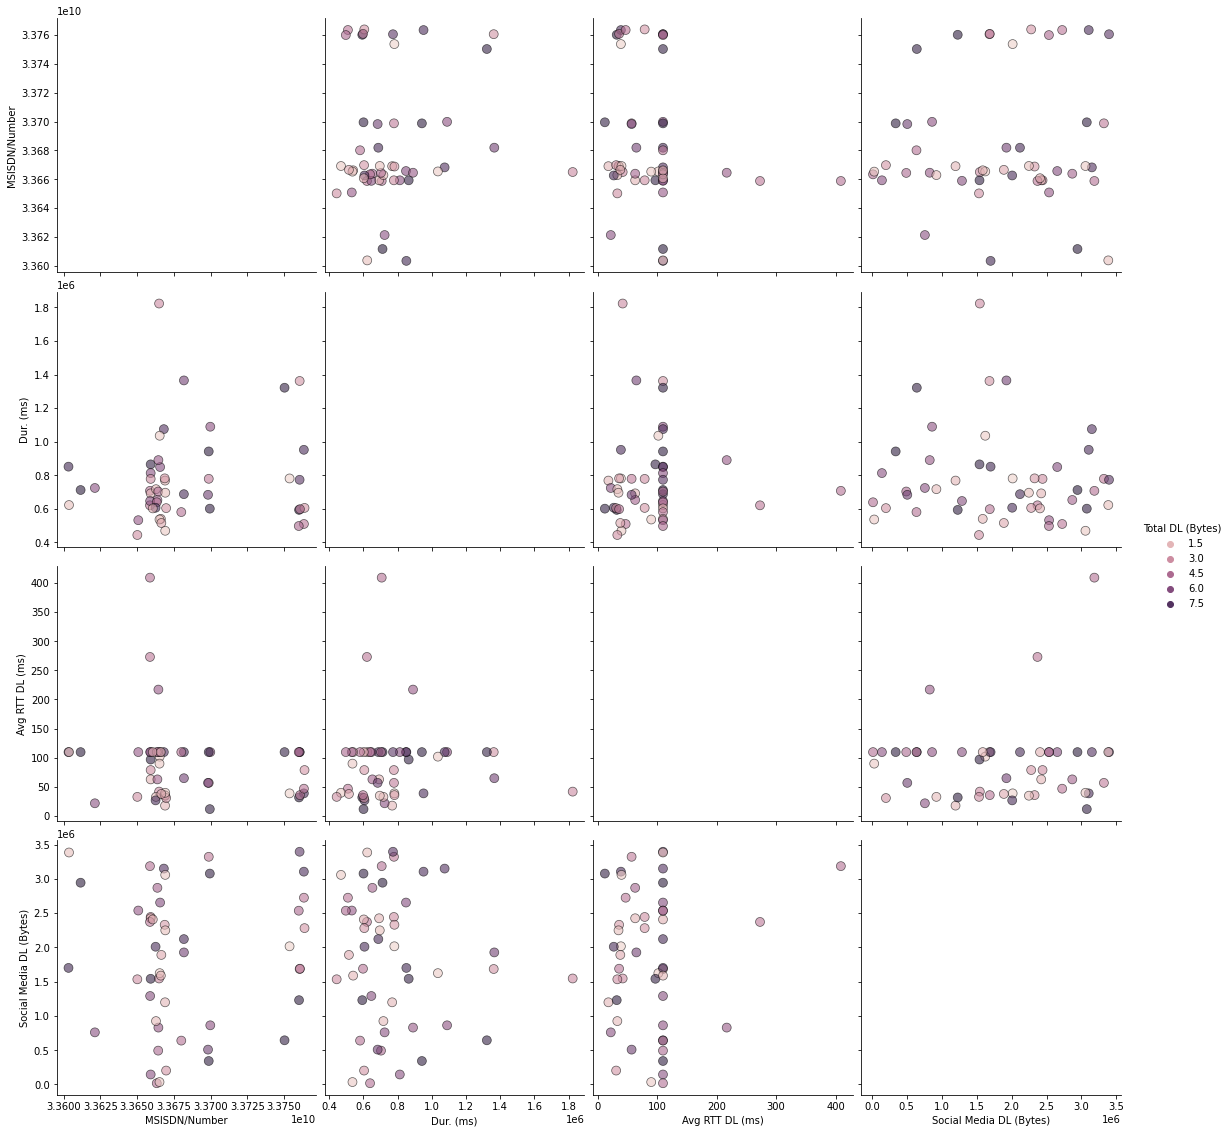

In [127]:
dfPair = db_explore.head(50)[["MSISDN/Number", "Dur. (ms)", "Avg RTT DL (ms)", "Social Media DL (Bytes)", "Total DL (Bytes)"]]
sns.pairplot(dfPair, hue = 'Total DL (Bytes)', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height=4)

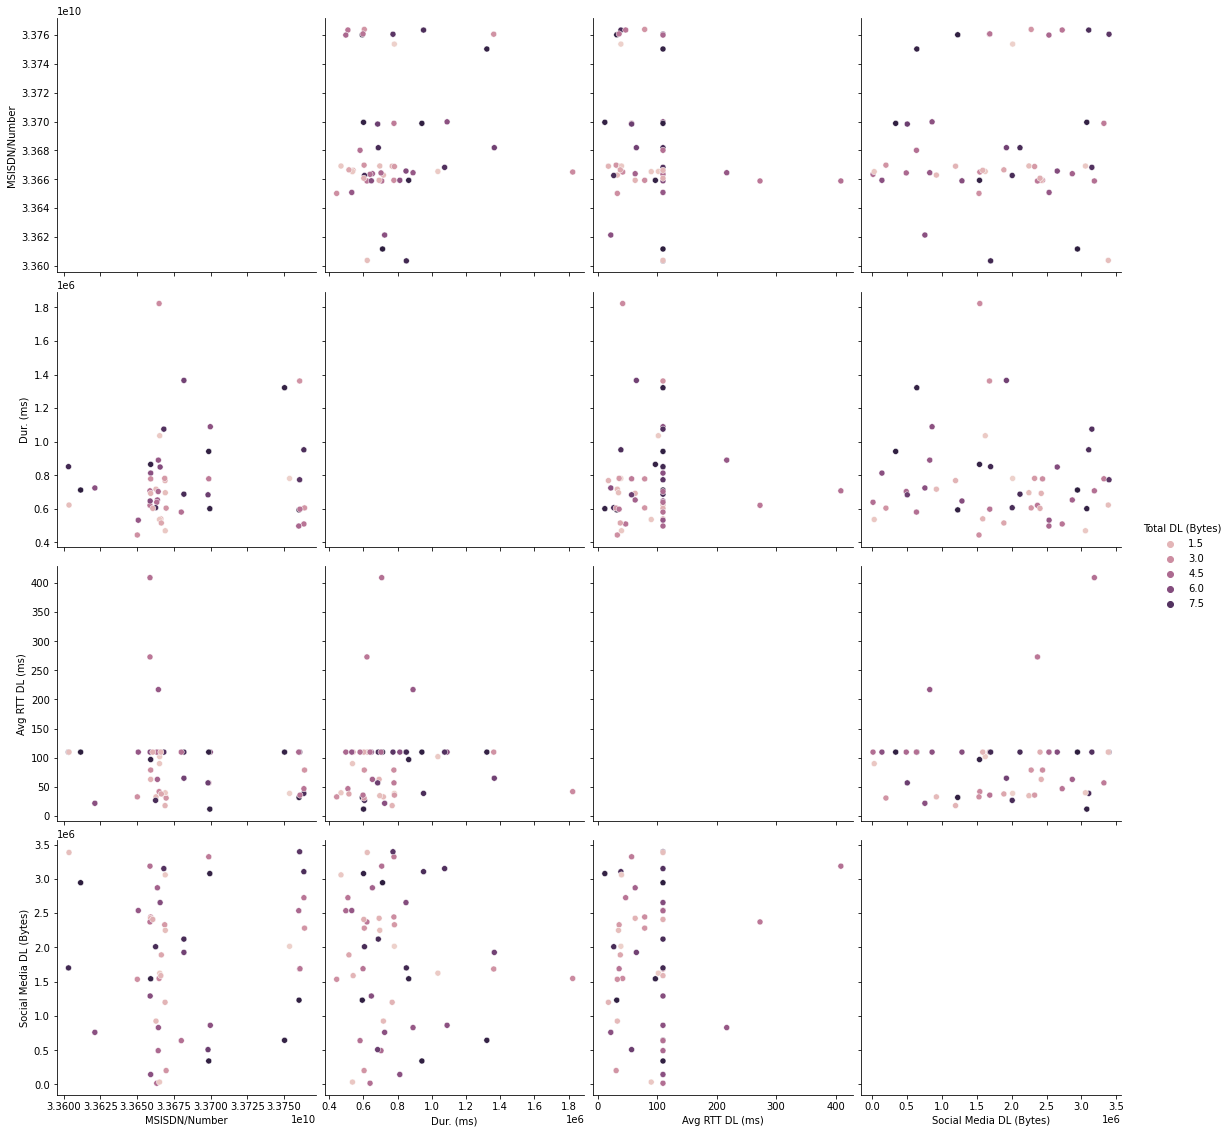

In [128]:
dfPair = db_explore.head(50)[["MSISDN/Number", "Dur. (ms)", "Avg RTT DL (ms)", "Social Media DL (Bytes)", "Total DL (Bytes)"]]
sns.pairplot(dfPair, hue = 'Total DL (Bytes)', diag_kind = 'kde',height=4)

### Deciles

### Selected columns based on separate PCA

In [160]:
decile_columns = ['MSISDN/Number','Dur. (ms)','Total UL (Bytes)', 'Total DL (Bytes)' ] # to limit the number of columns to be displayed
db_decile = db_explore[decile_columns]
# db_decile_group["Dur. Decile"] = pd.qcut(db_decile_group['Dur. (ms)'], 5, labels = ['Dec 1','Dec 2','Dec 3','Dec 4','Dec 5'])
# db_decile_group

### Five MSISDN deciles based on xDR Duration
#### contains all selected columns

In [158]:
db_decile_group_dur = db_decile.groupby(pd.qcut(db_decile["Dur. (ms)"], 5))
db_decile_group_dur.describe() # includes all selected columns

MSISDN/Number                                  \
                              count              mean           std   
Dur. (ms)                                                             
(7141.999, 45960.0]       30,001.00 33,666,169,023.96 37,931,087.46   
(45960.0, 86399.0]        47,703.00 33,672,344,952.70 38,885,518.57   
(86399.0, 92515.0]        12,298.00 33,673,034,118.92 39,435,686.52   
(92515.0, 148355.0]       29,999.00 33,666,819,176.75 38,541,370.82   
(148355.0, 1859336.0]     30,000.00 33,669,547,237.16 39,915,934.32   

                                                                             \
                                    min               25%               50%   
Dur. (ms)                                                                     
(7141.999, 45960.0]   33,601,008,617.00 33,650,083,088.00 33,663,478,205.00   
(45960.0, 86399.0]    33,601,007,832.00 33,658,633,221.00 33,663,797,508.00   
(86399.0, 92515.0]    33,601,027,208.00 33,658,658,865.00 33,663,797,508.00   
(92515.0, 148355.0]   33,601,001,722.00 33,650,209,052.00 33,663,119,775.00   
(148355.0, 1859336.0] 33,601,001,754.00 33,650,758,770.25 33,663,797,508.00   

                                                          Dur. (ms)  \
                                    75%               max     count   
Dur. (ms)                                                             
(7141.999, 45960.0]   33,672,363,308.00 33,769,455,327.00 30,001.00   
(45960.0, 86399.0]    33,673,886,489.00 33,769,469,548.00 47,703.00   
(86399.0, 92515.0]    33,674,664,006.50 33,769,407,386.00 12,298.00   
(92515.0, 148355.0]   33,671,399,594.00 33,769,469,548.00 29,999.00   
(148355.0, 1859336.0] 33,675,879,504.00 33,769,469,548.00 30,000.00   

                                                                              \
                            mean        std        min        25%        50%   
Dur. (ms)                                                                      
(7141.999, 45960.0]    27,814.03   9,678.73   7,142.00  19,826.00  28,066.00   
(45960.0, 86399.0]     76,409.03  13,532.71  45,961.00  64,046.00  86,073.00   
(86399.0, 92515.0]     87,625.79   1,862.82  86,400.00  86,400.00  86,400.00   
(92515.0, 148355.0]   117,382.66  16,916.44  92,516.00 101,468.50 115,971.00   
(148355.0, 1859336.0] 220,433.85 106,321.35 148,357.00 164,734.00 181,419.50   

                                              Total UL (Bytes)                \
                             75%          max            count          mean   
Dur. (ms)                                                                      
(7141.999, 45960.0]    35,416.00    45,960.00        30,001.00 41,141,541.00   
(45960.0, 86399.0]     86,399.00    86,399.00        47,703.00 41,138,521.42   
(86399.0, 92515.0]     88,620.75    92,515.00        12,298.00 41,204,052.37   
(92515.0, 148355.0]   132,430.50   148,355.00        29,999.00 41,087,431.94   
(148355.0, 1859336.0] 241,538.25 1,859,336.00        30,000.00 41,073,149.97   

                                                                              \
                                std          min           25%           50%   
Dur. (ms)                                                                      
(7141.999, 45960.0]   11,283,799.26 4,469,240.00 33,230,999.00 41,141,014.00   
(45960.0, 86399.0]    11,254,759.60 4,338,786.00 33,242,671.50 41,109,187.00   
(86399.0, 92515.0]    11,190,338.04 4,661,082.00 33,372,690.75 41,292,751.00   
(92515.0, 148355.0]   11,278,509.93 2,866,892.00 33,194,588.00 41,117,285.00   
(148355.0, 1859336.0] 11,336,428.59 5,276,726.00 33,151,227.25 41,171,129.50   

                                                  Total DL (Bytes)  \
                                75%           max            count   
Dur. (ms)                                                            
(7141.999, 45960.0]   49,076,042.00 78,331,311.00        30,001.00   
(45960.0, 86399.0]    49,017,823.50 77,157,382.0

### Deciles based on xDR duration
### Contains only the xDR duration data

In [157]:
db_decile_group_dur['Dur. (ms)'].describe() 

,count,mean,std,min,25%,50%,75%,max
Dur. (ms),,,,,,,,
"(7141.999, 45960.0]","30,001.00","27,814.03","9,678.73","7,142.00","19,826.00","28,066.00","35,416.00","45,960.00"
"(45960.0, 86399.0]","47,703.00","76,409.03","13,532.71","45,961.00","64,046.00","86,073.00","86,399.00","86,399.00"
"(86399.0, 92515.0]","12,298.00","87,625.79","1,862.82","86,400.00","86,400.00","86,400.00","88,620.75","92,515.00"
"(92515.0, 148355.0]","29,999.00","117,382.66","16,916.44","92,516.00","101,468.50","115,971.00","132,430.50","148,355.00"
"(148355.0, 1859336.0]","30,000.00","220,433.85","106,321.35","148,357.00","164,734.00","181,419.50","241,538.25","1,859,336.00"


### Decile Total DL Bytes sum

In [168]:
db_decile_group_dur['Total DL (Bytes)'].sum() 

Dur. (ms)
(7141.999, 45960.0]     13,649,755,092,570.00
(45960.0, 86399.0]      21,657,543,441,921.00
(86399.0, 92515.0]       5,582,355,454,979.00
(92515.0, 148355.0]     13,621,168,066,561.08
(148355.0, 1859336.0]   13,686,147,099,244.00
Name: Total DL (Bytes), dtype: float64

### Decile Total UL Bytes sum

In [169]:
db_decile_group_dur['Total UL (Bytes)'].sum() 

Dur. (ms)
(7141.999, 45960.0]     1,234,287,371,672.00
(45960.0, 86399.0]      1,962,430,887,505.00
(86399.0, 92515.0]        506,727,436,012.00
(92515.0, 148355.0]     1,232,581,870,658.29
(148355.0, 1859336.0]   1,232,194,499,175.00
Name: Total UL (Bytes), dtype: float64

### Correlation Analysis

### Correlation Analysis for the whole data

In [130]:
db.corr(method='pearson')

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
Bearer Id,1.00,0.00,-0.00,0.01,0.00,-0.00,0.16,-0.02,0.03,0.06,0.05,0.01,0.01,-0.07,0.04,0.06,0.06,-0.04,0.03,0.02,0.01,0.02,0.02,0.08,0.07,0.01,0.04,0.02,0.05,0.00,0.05,0.01,0.08,0.08,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00
Start ms,0.00,1.00,0.12,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00
End ms,-0.00,0.12,1.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00
Dur. (ms),0.01,0.00,-0.00,1.00,-0.02,0.02,-0.06,-0.04,-0.00,-0.17,-0.11,0.01,0.00,0.20,-0.19,-0.15,-0.10,0.11,-0.08,-0.03,-0.02,0.01,0.02,-0.07,-0.07,1.00,0.03,0.02,0.03,0.00,0.03,0.00,-0.06,-0.07,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.01,0.00,0.00,-0.00,0.00,-0.00,0.00
IMSI,0.00,-0.00,0.00,-0.02,1.00,-0.47,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.02,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.01,-0.00,0.00,-0.00,0.00,0.01
MSISDN/Number,-0.00,-0.00,-0.00,0.02,-0.47,1.00,0.01,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.02,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.00,0.00,-0.00,0.00,0.01,-0.00
IMEI,0.16,-0.00,-0.00,-0.06,-0.00,0.01,1.00,-0.00,0.13,0.30,0.24,0.07,0.02,-0.32,0.19,0.28,0.31,-0.20,0.15,0.09,0.06,0.09,0.11,0.41,0.37,-0.06,0.22,0.12,0.24,0.03,0.23,0.06,0.49,0.46,0.00,-0.01,-0.00,0.01,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00
Avg RTT DL (ms),-0.02,0.00,-0.00,-0.04,-0.00,0.00,-0.00,1.00,0.01,-0.02,-0.01,-0.00,-0.00,-0.01,0.01,0.01,-0.01,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.01,0.01,-0.04,0.00,-0.00,0.00,0.00,-0.00,0.00,0.01,0.01,0.00,-0.00,0.00,0.01,-0.00,-0.00,-0.00,0.00,-0.00,-0.01,-0.00,-0.01,-0.00,0.00,-0.00,-0.00
Avg RTT UL (ms),0.03,-0.00,-0.00,-0.00,-0.00,0.00,0.13,0.01,1.00,0.05,0.04,0.01,0.01,-0.05,0.02,0.04,0.05,-0.06,0.04,0.04,0.03,0.02,0.02,0.10,0.09,-0.00,0.04,0.05,0.05,0.04,0.04,0.06,0.10,0.09,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00
Avg Bearer TP DL (kbps),0.06,-0.00,0.00,-0.17,-0.00,-0.00,0.30,-0.02,0.05,1.00,0.56,0.07,0.01,-0.60,0.47,0.45,0.49,-0.35,0.29,0.10,0.07,0.09,0.09,0.41,0.38,-0.17,0.13,0.09,0.10,0.01,0.13,0.02,0.43,0.45,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.01,0.00,-0.00,0.00,0.01,0.00,0.00,-0.00


### Correlation Analysis for individual columns
#### Can be calculated using 'pearson’, ‘kendall’, ‘spearman methods; pearson being the standard correlation coefficient

In [172]:
cor_columns = ['Social Media DL (Bytes)', 'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
               'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 
               'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)'] 


db[cor_columns].corr(method='pearson')

,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes)
Social Media DL (Bytes),1.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.01,0.00
Social Media UL (Bytes),-0.00,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00
Google DL (Bytes),-0.00,0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
Google UL (Bytes),0.00,0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00
Email DL (Bytes),0.00,0.00,-0.00,-0.00,1.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00
Email UL (Bytes),-0.00,-0.00,0.00,-0.00,0.00,1.00,-0.00,-0.01,-0.00,0.00,-0.00,0.01,-0.00,0.00
Youtube DL (Bytes),-0.00,-0.00,0.00,0.00,0.00,-0.00,1.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00
Youtube UL (Bytes),0.00,-0.00,0.00,0.00,-0.00,-0.01,0.00,1.00,0.00,0.00,-0.00,0.00,0.00,-0.00
Netflix DL (Bytes),-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,1.00,0.00,-0.00,-0.00,-0.01,-0.00
Netflix UL (Bytes),0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,1.00,-0.00,-0.00,-0.01,-0.00


### Unapproximated correlation pairwise coefficients

In [188]:
db[cor_columns[0]].corr(db[cor_columns[1]], method = 'pearson')

-0.0005552550605629289

In [203]:
def Iterative_corr():
  for i in range(0,len(cor_columns)):
    print(f"Correlation between {cor_columns[i-1]} and {cor_columns[i]} is {db[cor_columns[i-1]].corr(db[cor_columns[i]], method = 'pearson')}")

In [204]:
Iterative_corr()

Correlation between Other UL (Bytes) and Social Media DL (Bytes) is 0.000610172935868667
Correlation between Social Media DL (Bytes) and Social Media UL (Bytes) is -0.0005552550605629289
Correlation between Social Media UL (Bytes) and Google DL (Bytes) is 0.0035420493604944817
Correlation between Google DL (Bytes) and Google UL (Bytes) is -0.00010337279625522597
Correlation between Google UL (Bytes) and Email DL (Bytes) is -0.0011566918702905404
Correlation between Email DL (Bytes) and Email UL (Bytes) is 0.002552705150782542
Correlation between Email UL (Bytes) and Youtube DL (Bytes) is -0.0003202909729306648
Correlation between Youtube DL (Bytes) and Youtube UL (Bytes) is 0.0024328000864883197
Correlation between Youtube UL (Bytes) and Netflix DL (Bytes) is 0.00042266596396286
Correlation between Netflix DL (Bytes) and Netflix UL (Bytes) is 0.0010652722724041523
Correlation between Netflix UL (Bytes) and Gaming DL (Bytes) is -0.0010506452722832409
Correlation between Gaming DL (Bytes

### Principal Data Analysis

In [206]:
db_explore_PCA = PCA(n_components=5)

In [208]:
db_explore_numeric = db_explore[important_columns_numeric]
db_explore_PC = db_explore_PCA.fit_transform(db_explore_numeric)

In [209]:
principal_db_explore_df = pd.DataFrame(data = db_explore_PC,
                        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])


In [210]:
principal_db_explore_df.head()

,PC1,PC2,PC3,PC4,PC5
0,"-2,975,608,806,588,633,088.00","204,092,727.47","-250,355,722.80","-654,836.49","-5,209,392.44"
1,"-2,975,608,828,622,561,792.00","-272,003,005.10","106,570,360.16","-1,623,907.90","11,892,773.26"
2,"-2,975,608,829,824,161,792.00","259,850,904.75","-11,618,980.76","-969,617.79","90,457,899.77"
3,"-2,975,608,831,186,461,184.00","-542,283,724.59","329,711,847.21","-1,802,615.66","80,447,249.64"
4,"-2,975,608,845,224,361,984.00","-155,032,182.39","129,944,020.15","-1,679,883.08","29,762,682.67"


In [211]:
print(f'Explained variation per principal component: {db_explore_PCA.explained_variance_ratio_}')

Explained variation per principal component: [1.00000000e+00 1.43202068e-20 7.11335536e-21 1.65264714e-21
 1.82559510e-22]
